In [1]:
import keras
from keras.models import Sequential

2025-06-23 18:24:55.110017: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-23 18:24:55.152159: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-23 18:24:55.826511: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import matplotlib.ticker as ticker
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Descriptors, AllChem
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect as Morgan
from rdkit.Chem.QED import qed
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import RDConfig
import os
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import os
import torch_geometric
from torch_geometric.data import Data
import numpy as np
from torch import nn
import copy
import tensorflow as tf
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer
import re

In [3]:
def load_vocab(file, args):
    """
    Load vocabulary and labels，并添加智能分词功能
    """
    f = open(file)
    lines = f.read().split('\n')[:-1]
    lines = [l.split() for l in lines]
    lines = [l for l in lines]
    labels = [l[1:] for l in lines][1:]

    if args.grammar == 'smiles':
        vocab={'#': 0, '(': 1, ')': 2, '-': 3, '.': 4, '/': 5, '1': 6, '2': 7, '3': 8, '4': 9, '5': 10, '6': 11, '7': 12, '=': 13, 'B': 14, 'Br': 15, 'C': 16, 'Cl': 17, 'E': 18, 'F': 19, 'I': 20, 'N': 21, 'O': 22, 'P': 23, 'S': 24, 'X': 25, '[ Co +2]': 26, '[ Co +]': 27, '[ Cr ]': 28, '[ Fe ]': 29, '[ Ir +]': 30, '[ Ni +2]': 31, '[ Pd +2]': 32, '[ Pd +]': 33, '[ Rh +]': 34, '[ Rh ]': 35, '[ Ru +2]': 36, '[ Ru +]': 37, '[B-1]': 38, '[B-]': 39, '[BH3-]': 40, '[C@@H]': 41, '[C@@]': 42, '[C@H]': 43, '[C@]': 44, '[C]': 45, '[H]': 46, '[K+]': 47, '[N+]': 48, '[N-1]': 49, '[N-]': 50, '[NH3+]': 51, '[N]': 52, '[Na+]': 53, '[O-1]': 54, '[O-]': 55, '[P+]': 56, '[P@@]': 57, '[P@H]': 58, '[P@]': 59, '[PH+]': 60, '[PH]': 61, '[S@@]': 62, '[S@]': 63, '[Si]': 64, '[c-]': 65, '[n+]': 66, '[nH]': 67, '\\': 68, 'c': 69, 'n': 70, 'o': 71, 'p': 72, 's': 73,'*': 74}

        
        # 添加无空格版本的金属元素token
        for token, idx in list(vocab.items()):
            if isinstance(token, str) and token.startswith('[') and ' ' in token:
                no_space_token = token.replace(' ', '')
                if no_space_token not in vocab:
                    vocab[no_space_token] = idx
    else:
        raise ValueError("Unknown grammar type")
    
    chars = list(vocab)
    chars += ('E',)  # End of smiles末尾添加 E
    chars += ('X',)  # Start of smiles开头添加 X
    
    # 定义SMILES分词函数
    def tokenize(smiles):
        tokens = []
        i = 0
        smiles = smiles.strip()
        while i < len(smiles):
            # 优先匹配方括号里的整个 token
            if smiles[i] == '[':
                m = re.match(r"\[[^\[\]]+\]", smiles[i:])
                if m:
                    tok = m.group(0)
                    tokens.append(tok)
                    i += len(tok)
                    continue
            # 尝试两字符 token（如 Cl、Br）
            if i + 1 < len(smiles) and smiles[i:i+2] in vocab:
                tokens.append(smiles[i:i+2])
                i += 2
                continue
            # 单字符 token
            if smiles[i] in vocab:
                tokens.append(smiles[i])
                i += 1
                continue
            # 未知字符，打 warning 并跳过
            print(f"警告: '{smiles[i]}' 不在词汇表中。")
            i += 1
        return tokens
    
    # token 列表 → 索引列表
    def map_tokens_to_ids(tokens):
        return [vocab.get(tok, vocab['X']) for tok in tokens]

    return vocab, chars, labels, tokenize, map_tokens_to_ids

In [4]:
def map_smiles_to_sequence(smiles_list, vocab, max_len=165):
    """
    将 SMILES 字符串映射为对应的符号序列，并填充到统一长度
    使用更智能的分词方法处理SMILES
    """
    sequences = []
    
    # 如果没有指定最大长度，则计算 SMILES 中的最大长度
    if max_len is None:
        max_len = max(len(smiles) for smiles in smiles_list)
    
    # 定义SMILES分词函数
    def tokenize(smiles):
        tokens = []
        i = 0
        smiles = smiles.strip()
        while i < len(smiles):
            # 优先匹配方括号里的整个 token
            if smiles[i] == '[':
                m = re.match(r"\[[^\[\]]+\]", smiles[i:])
                if m:
                    tok = m.group(0)
                    tokens.append(tok)
                    i += len(tok)
                    continue
            # 尝试两字符 token（如 Cl、Br）
            if i + 1 < len(smiles) and smiles[i:i+2] in vocab:
                tokens.append(smiles[i:i+2])
                i += 2
                continue
            # 单字符 token
            if smiles[i] in vocab:
                tokens.append(smiles[i])
                i += 1
                continue
            # 未知字符，打 warning 并跳过
            print(f"警告: '{smiles[i]}' 不在词汇表中。")
            tokens.append('X')  # 使用'X'替代未知字符
            i += 1
        return tokens
    
    # 遍历每个 SMILES 字符串
    for smiles in smiles_list:
        # 分词
        tokens = tokenize(smiles)
        
        # 将token映射为ID
        sequence = []
        for token in tokens:
            if token in vocab:
                sequence.append(vocab[token])
            else:
                # 如果token不在词汇表中，尝试查找无空格版本
                no_space_token = token.replace(' ', '')
                if no_space_token in vocab:
                    sequence.append(vocab[no_space_token])
                else:
                    print(f"警告: {token} 不在词汇表中。")
                    sequence.append(vocab['X'])  # 使用'X'替代未知token
        
        # 填充序列到 max_len
        sequence += [vocab['E']] * (max_len - len(sequence))  # 使用'E'填充至最大长度
        sequences.append(sequence)
    
    return sequences

In [5]:
def mol_from_smiles(smiles):
    """
    This function takes a list of smiles and returns a list of molecules
    """
    
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    mols = [m for m in mols if m is not None]
    return mols


In [6]:
def smiles_from_mol(mols):
    """
    This function takes a list of molecules and returns a list of smiles
    """
    smiles = [Chem.MolToSmiles(m, canonical=True) for m in mols]
    
    return smiles


In [7]:
import pandas as pd
import torch
def load_and_map_smiles(file, args):
    """
    读取 CSV 文件并将 SMILES 映射为符号序列，同时计算每个 SMILES 对应的分子量
    支持 Sub1 和 Sub2 两个替代分子列
    """
    # 读取 CSV
    df = pd.read_csv(file)
    smiles_list = df['SMILES'].tolist()
    
    # 加载词表和字符、标签信息以及分词函数
    vocab, chars, labels, tokenize, map_tokens_to_ids = load_vocab(file, args)
    
    # 将主 SMILES 映射为符号序列
    sequences = []
    for smiles in smiles_list:
        tokens = tokenize(smiles)
        ids = map_tokens_to_ids(tokens)
        # 填充序列到统一长度
        max_len = 165  # 或者其他想要的长度
        ids += [vocab['E']] * (max_len - len(ids))
        sequences.append(ids)
    
    # 计算每个 SMILES 的分子对象列表（可用于分子量等计算）
    mols = mol_from_smiles(smiles_list)
    
    # 读取 Sub1、Sub2 和 OUTPUT
    sub1_sequences, sub2_sequences, output_values = None, None, None
    if {'Sub1', 'Sub2', 'OUTPUT'}.issubset(df.columns):
        sub1_list = df['Sub1'].tolist()
        sub2_list = df['Sub2'].tolist()
        output_values = df['OUTPUT'].tolist()
        
        # 映射 Sub1 和 Sub2
        sub1_sequences = []
        for smiles in sub1_list:
            tokens = tokenize(smiles)
            ids = map_tokens_to_ids(tokens)
            ids += [vocab['E']] * (max_len - len(ids))
            sub1_sequences.append(ids)
            
        sub2_sequences = []
        for smiles in sub2_list:
            tokens = tokenize(smiles)
            ids = map_tokens_to_ids(tokens)
            ids += [vocab['E']] * (max_len - len(ids))
            sub2_sequences.append(ids)
    else:
        missing = [col for col in ['Sub1', 'Sub2', 'OUTPUT'] if col not in df.columns]
        print(f"警告: CSV文件中缺少列: {', '.join(missing)}")

    # 转为 PyTorch Tensor
    sequences_tensor = torch.tensor(sequences, dtype=torch.long)

    # 返回主 SMILES 列表、主序列 Tensor、Sub1 、Sub2 、OUTPUT 值列表以及字符表
    return smiles_list, sequences_tensor, sub1_sequences, sub2_sequences, output_values, chars, tokenize, map_tokens_to_ids

In [8]:
def split_data(smiles_list, sequences_tensor, sub1_seq, sub2_seq, output_values, test_ratio=0.2):
    """
    将数据拆分为训练集和测试集，确保每个 SMILES 与其主序列、两个替代序列和输出值配对
    接收替代序列列表而非 Tensor
    """
    (train_smiles, test_smiles,
     train_seq, test_seq,
     train_sub1, test_sub1,
     train_sub2, test_sub2,
     train_output, test_output) = train_test_split(
        smiles_list, sequences_tensor,
        sub1_seq, sub2_seq,
        output_values,
        test_size=test_ratio,
        random_state=42
    )
    return (train_smiles, test_smiles,
            train_seq, test_seq,
            train_sub1, test_sub1,
            train_sub2, test_sub2,
            train_output, test_output)

In [9]:
# 示例调用
args = type('', (), {})()
args.grammar = 'smiles'

# 加载数据
smiles_list, sequences_tensor, sub1_seq, sub2_seq, output_values, chars, tokenize, map_tokens_to_ids = load_and_map_smiles('AHO.csv', args)# 这个地方换成新数据集

# 划分训练和测试集
(train_smiles, test_smiles,
 train_seq, test_seq,
 train_sub1, test_sub1,
 train_sub2, test_sub2,
 train_output, test_output) = split_data(
    smiles_list, sequences_tensor,
    sub1_seq, sub2_seq,
    output_values,
    test_ratio=0.2
)

# # # 输出示例
# # print(f"训练集大小: {len(train_smiles)}, 测试集大小: {len(test_smiles)}")
# # for i in range(min(5, len(train_smiles))):
# #     print(f"SMILES: {train_smiles[i]}, 主序列: {train_seq[i]}, Sub1序列: {train_sub1[i]}, Sub2序列: {train_sub2[i]}, OUTPUT: {train_output[i]}")

In [10]:
# def convert_to_smiles(vector, char):
#     """
#     Convert a vector to a SMILES string
#     """
#     list_char = list(char)
#     vector = vector.astype(int)
#     return "".join(map(lambda x: list_char[x], vector)).strip()

def convert_to_smiles(vector, char):
    """
    Convert a vector to a SMILES string
    """
    list_char = list(char)
    try:
        vector = vector.numpy()
    except AttributeError:
        pass  # already a NumPy array
    vector = vector.astype(int)
    return "".join(map(lambda x: list_char[x], vector)).strip()



In [11]:
import os
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import os
import torch_geometric
from torch_geometric.data import Data
import numpy as np
from torch import nn
import copy
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow_addons.seq2seq import BasicDecoder, BahdanauAttention, AttentionWrapper

/root/miniconda3/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [12]:
class Encoder(tf.keras.Model):
    def __init__(self, batch_size, unit_size, latent_size, vocab_size, n_rnn_layer, seq_length, embedding):
        super().__init__()
        self.batch_size = batch_size
        self.unit_size = unit_size
        self.latent_size = latent_size
        self.vocab_size = vocab_size
        self.n_rnn_layer = n_rnn_layer
        self.seq_length = seq_length
        self.embedding = embedding  # 共享 embedding 层（假设 X 和 C 都是 SMILES）

        initializer = tf.keras.initializers.glorot_uniform(seed=42)
        ker_reg = tf.keras.regularizers.l2(0.00001)

        # 主序列编码器（X）
        self.rnn_layer_encode = [
            tf.keras.layers.LSTM(self.unit_size, return_sequences=True, return_state=True,
                                 kernel_initializer=initializer, kernel_regularizer=ker_reg)
            for _ in range(self.n_rnn_layer)
        ]

        # 条件序列编码器（C）
        self.cond_encoder = tf.keras.layers.LSTM(self.unit_size, return_sequences=False, return_state=False,
                                                 kernel_initializer=initializer, kernel_regularizer=ker_reg)

        # 输出到均值/方差
        self.dense_mean = tf.keras.layers.Dense(self.latent_size, name='mean',
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1),
                                                kernel_regularizer=ker_reg)
    def call(self, inputs_XCL, training=False):
        # unpack inputs
        X, C, L = inputs_XCL  # X, C: [batch, seq_len], L: [batch]

        X = tf.convert_to_tensor(X.numpy(), dtype=tf.int32)  # 确保是整数类型
        C = tf.convert_to_tensor(C.numpy(), dtype=tf.int32)  # 确保是整数类型
        
        # SMILES 嵌入（共享 embedding）
        X_emb = self.embedding(X, training=training)       # shape: [batch, seq_len, emb_dim]
        C_emb = self.embedding(C, training=training)       # shape: [batch, cond_seq_len, emb_dim]

        # 条件 SMILES 编码
        C_encoded = self.cond_encoder(C_emb, training=training)  # shape: [batch, unit_size]

        # 将 C 的语义表示平铺到每个时间步
        C_tiled = tf.tile(tf.expand_dims(C_encoded, 1), [1, self.seq_length, 1])  # [batch, seq_len, unit_size]

        # 拼接条件向量到每个时间步
        inputs = tf.concat([X_emb, C_tiled], axis=-1)  # [batch, seq_len, emb_dim + unit_size]

        # 构建掩码（mask padding）
        mask = tf.sequence_mask(L, maxlen=self.seq_length, dtype=tf.bool)

        output_state = []
        for i in range(self.n_rnn_layer):
            inputs, *state_out = self.rnn_layer_encode[i](inputs, training=training, mask=mask)
            output_state.append(state_out)

        c, h = output_state[-1]

        # 计算隐变量的均值
        z_mean = self.dense_mean(h, training=training)

        return z_mean


In [13]:
class Decoder(tf.keras.Model):
    def __init__(self, batch_size, unit_size, latent_size, vocab_size, n_rnn_layer, embedding):
        super().__init__()
        self.batch_size = batch_size
        self.unit_size = unit_size
        self.latent_size = latent_size
        self.vocab_size = vocab_size
        self.n_rnn_layer = n_rnn_layer
        self.embedding = embedding
        # self.dropout = tf.keras.layers.Dropout(0.2)

        initializer = tf.keras.initializers.glorot_uniform(seed=42)
        ker_reg = tf.keras.regularizers.l2(0.00001)

        # 多层 LSTM 解码器
        self.rnn_layer_decode = [
            tf.keras.layers.LSTM(self.unit_size, return_sequences=True, return_state=True,
                                 kernel_initializer=initializer, kernel_regularizer=ker_reg)
            for _ in range(self.n_rnn_layer)
        ]

        # 条件 SMILES 序列编码器（和 encoder 的一致）
        self.cond_encoder = tf.keras.layers.LSTM(
            self.unit_size, return_sequences=False, return_state=False,
            kernel_initializer=initializer, kernel_regularizer=ker_reg
        )

        # 输出层
        self.dense = tf.keras.layers.Dense(self.vocab_size,
                                           kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1),
                                           kernel_regularizer=ker_reg)
        self.softmax = tf.keras.layers.Softmax()

    def call(self, inputs_XZCL, state=None, training=False):
        X, Z, C, L = inputs_XZCL  # X: SMILES序列，Z: latent，C: 条件SMILES，L: 序列长度

        seq_length = tf.shape(X)[1]

        # --- 嵌入 ---
        X_emb = self.embedding(X, training=training)        # [batch, seq_len, emb_dim]
        C_emb = self.embedding(C, training=training)        # [batch, cond_seq_len, emb_dim]

        # --- 条件编码 ---
        C_encoded = self.cond_encoder(C_emb, training=training)  # [batch, unit_size]
        C_tiled = tf.tile(tf.expand_dims(C_encoded, 1), [1, seq_length, 1])  # [batch, seq_len, unit_size]

        # --- Z 平铺 ---
        Z = tf.tile(tf.expand_dims(Z, axis=1), [1, seq_length, 1])  # [batch, seq_len, latent_size]

        # --- 拼接输入 ---
        inputs = tf.concat([Z, X_emb, C_tiled], axis=-1)  # [batch, seq_len, latent + emb + cond]

        # inputs = self.dropout(inputs, training=training)
        mask = tf.sequence_mask(L, maxlen=seq_length, dtype=tf.bool)

        # --- 解码 ---
        output_state = []
        if training:
            for i in range(self.n_rnn_layer):
                inputs, *state_out = self.rnn_layer_decode[i](inputs, training=training, mask=mask)
                output_state.append(state_out)
        else:
            if state is None:
                state = [[tf.zeros([tf.shape(X)[0], self.unit_size]), tf.zeros([tf.shape(X)[0], self.unit_size])]
                         for _ in range(self.n_rnn_layer)]
            for i in range(self.n_rnn_layer):
                inputs, *state_out = self.rnn_layer_decode[i](inputs, training=training,
                                                              initial_state=state[i], mask=mask)
                output_state.append(state_out)

        # --- 输出层 ---
        X2 = tf.reshape(inputs, [-1, tf.shape(inputs)[-1]])
        X3_logits = self.dense(X2, training=training)
        X3_logits = tf.reshape(X3_logits, [-1, seq_length, tf.shape(X3_logits)[-1]])
        X3 = self.softmax(X3_logits)

        return X3, X3_logits, output_state
    
    def generate_random_sample(self, C, start_codon, char, max_len=165, return_smiles=True, stop_token_id=None):
        """
        根据条件向量生成 SMILES 序列。

        Args:
            C: 条件向量，shape = [batch_size, cond_dim]
            start_codon: 起始 token 的 ID，shape = [batch_size, 1]
            char: id -> token 的列表（如 ['C', 'O', ...]）
            max_len: 最长生成长度
            return_smiles: 是否返回 SMILES 字符串
            stop_token_id: 停止生成的 token ID（通常为 'E'）

        Returns:
            SMILES 序列列表或 token 序列
        """
        batch_size = C.shape[0]
        latent = tf.random.normal(shape=(batch_size, self.latent_size))  # 随机潜变量
        X_pred = tf.cast(start_codon, tf.int32)  # 初始输入，形状 [batch, 1]
        preds = []
        state = None
        L = tf.ones((batch_size,), dtype=tf.int32)

        for _ in range(max_len):
            logits, _, state = self([X_pred, latent, C, L], state=state, training=False)
            last_logits = logits[:, -1, :]  # shape = [batch, vocab_size]
            probs = tf.nn.softmax(last_logits)
            sampled_token = tf.random.categorical(tf.math.log(probs), num_samples=1)
            sampled_token = tf.squeeze(sampled_token, axis=-1)  # shape: [batch]
            preds.append(sampled_token)
            X_pred = tf.expand_dims(sampled_token, axis=1)

        # 拼接生成序列
        token_id_seqs = tf.stack(preds, axis=1).numpy()  # shape = [batch, max_len]

        if not return_smiles:
            return token_id_seqs

        # 如果要求 SMILES 输出，进行解码 + 截断
        generated_smiles = []
        for seq in token_id_seqs:
            if stop_token_id is not None:
                try:
                    end_idx = np.where(seq == stop_token_id)[0][0]
                    seq = seq[:end_idx]
                except IndexError:
                    pass  # 没有 'E'，保留完整序列
            if len(seq) == 0:
                continue
            smiles = convert_to_smiles(seq, char)
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                generated_smiles.append(smiles)

        return generated_smiles
    
    def generate_topk_sampling(self, C, start_codon, char, k=5, max_len=165, return_smiles=True, stop_token_id=None):

        batch_size = C.shape[0]
        latent = tf.random.normal(shape=(batch_size, self.latent_size))  # 随机潜变量
        X_pred = tf.cast(start_codon, tf.int32)  # 初始输入，形状 [batch, 1]
        preds = []
        state = None
        L = tf.ones((batch_size,), dtype=tf.int32)
        
        for _ in range(max_len):
            logits, _, state = self([X_pred, latent, C, L], state=state, training=False)
            last_logits = logits[:, -1, :]  # shape = [batch, vocab_size]
            
            # Top-k 采样
            topk_values, topk_indices = tf.nn.top_k(last_logits, k=k)  # shape: [batch, k]
            topk_probs = tf.nn.softmax(topk_values)  # 对 top-k 值进行 softmax
            
            # 从 top-k 中采样
            sampled_indices = tf.random.categorical(tf.math.log(topk_probs), num_samples=1)  # shape: [batch, 1]
            sampled_indices = tf.squeeze(sampled_indices, axis=-1)  # shape: [batch]
            
            # 获取实际的 token ID
            sampled_token = tf.gather(topk_indices, sampled_indices, batch_dims=1)  # shape: [batch]
            
            preds.append(sampled_token)
            X_pred = tf.expand_dims(sampled_token, axis=1)
        
        # 拼接生成序列
        token_id_seqs = tf.stack(preds, axis=1).numpy()  # shape = [batch, max_len]
        
        if not return_smiles:
            return token_id_seqs
        
        # 如果要求 SMILES 输出，进行解码 + 截断
        generated_smiles = []
        for seq in token_id_seqs:
            if stop_token_id is not None:
                try:
                    end_idx = np.where(seq == stop_token_id)[0][0]
                    seq = seq[:end_idx]
                except IndexError:
                    pass  # 没有 'E'，保留完整序列
            if len(seq) == 0:
                continue
            smiles = convert_to_smiles(seq, char)
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                generated_smiles.append(smiles)
        
        return generated_smiles
    
    def generate_topp_sampling(self, C, start_codon, char, p=0.95, max_len=165, return_smiles=True, stop_token_id=None):
        batch_size = C.shape[0]
        latent = tf.random.normal(shape=(batch_size, self.latent_size))  
        X_pred = tf.cast(start_codon, tf.int32)  
        preds = []
        state = None
        L = tf.ones((batch_size,), dtype=tf.int32)
        
        for _ in range(max_len):
            logits, _, state = self([X_pred, latent, C, L], state=state, training=False)
            last_logits = logits[:, -1, :]  
            probs = tf.nn.softmax(last_logits)
            
            # 按概率降序排序
            sorted_probs, sorted_indices = tf.nn.top_k(probs, k=tf.shape(probs)[-1])
            
            # 计算累积概率
            cumulative_probs = tf.cumsum(sorted_probs, axis=1)
            
            # 创建掩码
            mask = cumulative_probs <= p
            
            # 修改这里：先创建float类型的one-hot向量，再转换为bool
            first_token_mask = tf.cast(
                tf.one_hot(0, depth=tf.shape(mask)[1], dtype=tf.float32),
                dtype=tf.bool
            )
            first_token_mask = tf.tile(tf.expand_dims(first_token_mask, 0), [batch_size, 1])
            mask = tf.logical_or(mask, first_token_mask)
            
            # 应用掩码
            filtered_probs = tf.where(mask, sorted_probs, 0.0)
            
            # 重新归一化
            filtered_probs = filtered_probs / tf.reduce_sum(filtered_probs, axis=1, keepdims=True)
            
            # 从过滤后的概率中采样
            sampled_indices = tf.random.categorical(tf.math.log(filtered_probs + 1e-8), num_samples=1)
            sampled_indices = tf.squeeze(sampled_indices, axis=-1)
            
            # 获取实际的 token ID
            sampled_token = tf.gather(sorted_indices, sampled_indices, batch_dims=1)
            
            preds.append(sampled_token)
            X_pred = tf.expand_dims(sampled_token, axis=1)
        
        # 拼接生成序列
        token_id_seqs = tf.stack(preds, axis=1).numpy()
        
        if not return_smiles:
            return token_id_seqs
        
        # 转换为 SMILES
        generated_smiles = []
        for seq in token_id_seqs:
            if stop_token_id is not None:
                try:
                    end_idx = np.where(seq == stop_token_id)[0][0]
                    seq = seq[:end_idx]
                except IndexError:
                    pass
            if len(seq) == 0:
                continue
            smiles = convert_to_smiles(seq, char)
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                generated_smiles.append(smiles)
        
        return generated_smiles
        
    # 贪婪生成
    def generate(self, C, start_codon, seq_length=165):
        # z = tf.keras.backend.random_normal(shape=(C.shape[0], self.latent_size), mean=0.0, stddev=1.0) # 从标准正态分布中随机采样潜在变量 z
        z = tf.random.normal(shape=(C.shape[0], self.latent_size), mean=0.0, stddev=1.0) # 从标准正态分布中随机采样潜在变量 z
        C = tf.cast(C, tf.int32)#将条件向量 C 转换为 float32 类型，确保与模型的其他部分兼容。
        
        
        X_pred = tf.cast(start_codon, tf.int32)# start_codon是起始密码子
        # X_pred = tf.expand_dims(tf.cast(start_codon, tf.int32), axis=1)

        preds = []
        state = None
#         L = np.ones(shape=(C.shape[0],), dtype=np.int32)
        L = tf.ones(shape=(tf.shape(C)[0],), dtype=tf.int32)
        
        for i in range(seq_length):

            if i == 0:
                Y_hat, _, state = self.call([X_pred, z, C, L], state=None, training=False) # traini·ng=False: 表示当前处于推理模式
                Y_hat = tf.argmax(Y_hat, axis=-1)
            else:
                Y_hat, _, state = self.call([Y_hat, z, C, L], state=state, training=False)
                Y_hat = tf.argmax(Y_hat, axis=-1)

            preds.append(Y_hat)
        
        preds = tf.stack(preds, axis=1)
        preds = tf.squeeze(preds, axis=2)
        preds = tf.cast(preds, tf.int32)
        return preds



        
class Model(tf.keras.Model):
    def __init__(self,vocab):
        super(Model, self).__init__()
        self.batch_size = 512 #2048 initial; close to 100 for tuning
        self.unit_size = 256
        self.latent_size = 200 #200
        self.vocab_size = len(vocab)
        self.n_rnn_layer = 3
        self.seq_length = 165
        self.lr = 1e-4 #1e-4 initial #1e-5 for tuning
        self.kl_beta = 1 # 1 现在这个是mmd_loss的权重
        self.vocab = vocab


        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)

        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.latent_size, embeddings_initializer=tf.keras.initializers.random_uniform(minval=-0.1, maxval=0.1))
        self.encoder = Encoder(self.batch_size, self.unit_size, self.latent_size, self.vocab_size, self.n_rnn_layer, self.seq_length,
                                self.embedding)
        self.decoder = Decoder(self.batch_size, self.unit_size, self.latent_size, self.vocab_size, self.n_rnn_layer, self.embedding)

    def call(self, inputs, state=None, training=False):
        X, C, L = inputs # 输入的X,C,L分别是SMILES,序列、条件向量、序列长度
        z_mean = self.encoder([X, C, L], training=training)
        # 编码器将输入的SMILES序列映射到潜在空间，得到潜在变量 z 及其均值 z_mean 和对数方差 z_logvar。
        Y_hat, Y_hat_logits, state = self.decoder([X, z_mean, C, L], state=state, training=training)
        # 解码器根据潜在变量 z 和条件向量 C 输出生成的分子序列预测 Y_hat 和对应的logits。
        return Y_hat, Y_hat_logits, z_mean, state

    def rbf_kernel(self, x, y, sigma=1.0):#高斯核函数，用于计算MMD
        x_norm = tf.reduce_sum(tf.square(x), axis=1, keepdims=True)
        y_norm = tf.reduce_sum(tf.square(y), axis=1, keepdims=True)
        cross_term = tf.matmul(x, y, transpose_b=True)
        dists = x_norm - 2 * cross_term + tf.transpose(y_norm)
        return tf.exp(-dists / (2 * sigma ** 2))

    def compute_mmd(self, z, prior_z=None, kernel='rbf', epsilon=1e-8):
        """计算编码器输出 z 与标准正态分布之间的 MMD"""
        if prior_z is None:
            prior_z = tf.random.normal(tf.shape(z))
        Kxx = self.rbf_kernel(z, z)
        Kyy = self.rbf_kernel(prior_z, prior_z)
        Kxy = self.rbf_kernel(z, prior_z)
    
        mmd = tf.reduce_mean(Kxx) + tf.reduce_mean(Kyy) - 2 * tf.reduce_mean(Kxy)
        return tf.maximum(mmd, epsilon) # 确保 MMD 至少为 epsilon，防止后续 log(0)
   
    def loss(self, Y, L, Y_hat, Y_hat_logits, z_mean):
        weights = tf.sequence_mask(L, maxlen=self.seq_length, dtype=tf.float32)
        z = z_mean
        # print(f'Y_hat_logits shape: {Y_hat_logits.shape},Y shape: {Y.shape},weights shape: {weights.shape}')
        
        reconstruction_loss = tf.reduce_mean(tfa.seq2seq.sequence_loss(logits=Y_hat_logits, targets=Y, weights=weights))
      
        mmd_loss = self.compute_mmd(z_mean, prior_z=None, kernel='rbf', epsilon=1e-8)
                
        total_loss = reconstruction_loss + self.kl_beta*mmd_loss
        # 最终的损失是重构损失和KL损失的加权和
        return {'loss': total_loss, 'reconstruction': reconstruction_loss, 'mmd_loss': mmd_loss}   
    

    def train_batch(self, data):# 用于训练模型的一个批次数据
        X, C, Y, L = data # X：由SMILES或者SELIES生成的序列
        # Y: 真实的目标值（通常是分子的真实 SMILES 或 SELFIES 表示）。
        X = tf.convert_to_tensor(X.numpy(), dtype=tf.int32)  # 确保是整数类型
        Y = tf.convert_to_tensor(Y.numpy(), dtype=tf.int32)  # 确保是整数类型
        # Y = tf.convert_to_tensor(Y, dtype=tf.string)
        C = tf.convert_to_tensor(C, dtype=tf.float32)
        L = tf.convert_to_tensor(L, dtype=tf.int32)

        with tf.GradientTape() as tape:# 上下文管理器记录计算图中的操作，以便后续计算梯度。
            Y_hat, Y_hat_logits, z_mean, state = self.call([X, C, L ], training=True)
            # loss_batch 是一个字典，包含多个损失项
            loss_batch = self.loss(Y, L, Y_hat, Y_hat_logits, z_mean)
            # 计算正则化损失
            loss_batch['Regularization'] = tf.reduce_mean(self.encoder.losses) + tf.reduce_mean(self.decoder.losses) # 编码器中的正则化损失（例如 L2 正则化）的平均值和解码器中的正则化损失的平均值
            loss_batch['loss'] += loss_batch['Regularization'] # 将正则化损失添加到总损失中
        gradients = tape.gradient(loss_batch['loss'], self.encoder.trainable_variables+self.decoder.trainable_variables) # 使用 tape.gradient 计算总损失对所有可训练变量的梯度
        self.optimizer.apply_gradients(zip(gradients, self.encoder.trainable_variables+self.decoder.trainable_variables)) # 使用优化器更新模型参数
        return loss_batch # 现在这个loss_batch包括四项：loss总损失、reconstruction重构损失，KL 散度损失，正则化损失
    
    def train(self, dataset_train, dataset_val, epochs, patience):# patience: 早停机制的容忍度（连续多少轮验证损失不下降时停止训练）
        history = {} # 一个字典，用于记录每轮训练和验证的损失值
        best_val_loss = tf.constant(np.inf)
        count = 0 # 记录连续验证损失未下降的轮数
        X_train, Y_train, C_train, L_train = dataset_train # 训练数据
        X_val, Y_val, C_val, L_val = dataset_val #  验证数据

        if len(X_val) == 0:
            raise ValueError("Validation dataset is empty. Please provide valid validation data.")

        from tqdm.auto import tqdm # 使用 tqdm 提供进度条功能，方便观察训练过程
        for epoch in tqdm(range(epochs), desc='Epochs', leave=True):# 创建一个带有进度条的训练循环 设置进度条的描述信息为 "Epochs"。leave=True: 在训练完成后保留进度条
            start = time.time() # 记录每轮训练的开始时间，用于计算每轮训练耗时
            loss_batches = {} # 一个字典，用于存储每个批次的损失值

            for i in range(len(X_train)// self.batch_size):
                X_batch = X_train[i*self.batch_size:i*self.batch_size + self.batch_size]
                Y_batch = Y_train[i*self.batch_size:i*self.batch_size + self.batch_size]
                C_batch = C_train[i*self.batch_size:i*self.batch_size + self.batch_size]
                L_batch = L_train[i*self.batch_size:i*self.batch_size + self.batch_size]

                loss_batch = self.train_batch([X_batch, C_batch, Y_batch, L_batch])
                for key, valu in loss_batch.items():
                    loss_batches.setdefault(key, []).append(valu) #如果字典中不存在该键，则初始化为空列表。将当前批次的损失值追加到对应列表中。
                
            for i in range(len(X_val)//self.batch_size):
                X_val_batch = X_val[i*self.batch_size:i*self.batch_size + self.batch_size]
                Y_val_batch = Y_val[i*self.batch_size:i*self.batch_size + self.batch_size]
                C_val_batch = C_val[i*self.batch_size:i*self.batch_size + self.batch_size]
                L_val_batch = L_val[i*self.batch_size:i*self.batch_size + self.batch_size]
                
                Y_hat_val_batch, Y_hat_logits_batch, z_mean_val_batch, state_val_batch = self.call([X_val_batch, C_val_batch, L_val_batch], training=True)# add training true
                
                loss_val_batch = self.loss(Y_val_batch, L_val_batch, Y_hat_val_batch, Y_hat_logits_batch, z_mean_val_batch)# 调用 self.loss 方法计算验证损失
                
                
                for key, valu in loss_val_batch.items():
                    loss_batches.setdefault(key+'_val', []).append(valu)#将每个验证损失项存储到 loss_batches 字典中，键名加上后缀 _val 表示验证损失。

            for key, valu in loss_batches.items():
                history.setdefault(key, []).append(tf.reduce_mean(valu))# 对每个损失项取平均值，并将其添加到 history 字典中。

            # print("Loss val batch:", loss_val_batch)
            # print("Loss batches:", loss_batches)
            #构造一条日志字符串 stampa，包含当前轮次、所有损失值以及训练耗时。
            stampa = f'Epoch: {epoch + 1}/{epochs}, '
            for key, valu in history.items():
                stampa += f'{key}: {valu[-1].numpy():.4f}, '

            stampa += f'Time: {time.time() - start:.2f}s'
            print(stampa)

            # 监控验证损失，并进行早停判断
            if 'loss_val' in history and history['loss_val'][-1] < best_val_loss:
                best_val_loss = history['loss_val'][-1]
                count = 0
            else:
                count += 1
    
            # Early stopping
            if count == patience:
                print('Early stopping')
                return history  # 如果触发早停机制，返回历史记录
   
        return history

    
    # def plot_loss(self, history, path):
    def plot_loss(self, history):
        plt.figure(figsize=(10, 5))
        plt.plot(history['loss'], label='Train')
        plt.plot(history['loss_val'], label='Validation')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


# def plot_loss_kl(self, history, path):
    def plot_loss_mmd(self, history):
        plt.figure(figsize=(10, 5))
        plt.plot(history['mmd_loss'], label='Train')
        plt.plot(history['mmd_loss_val'], label='Validation')
        plt.xlabel('Epochs')
        plt.ylabel('mmd_loss')
        plt.legend()
        plt.show()

In [14]:
def load_model(args):
    # 用于模型推理，也可在现有模型的基础上进行训练，也可以加载之前的权重并重新开始训练。
    # 话可用于加载模型来评估性能
    model = Model(args.vocab)
    dummy_data = (tf.zeros((1, args.seq_length), dtype=tf.int32),
                                tf.zeros((1, args.num_properties), dtype=tf.float32),
                                tf.constant([args.seq_length]))
    _ = model(dummy_data)

    model.load_weights(str(args.save_dir) + f'/model_{args.grammar}_{args.model_type}_{args.target}_weights.h5')

    return model

In [15]:
# 假设 seq_length 是序列的最大长度
seq_length = train_seq.shape[1]

# 将替代序列和输出转换为 numpy 数组
train_sub1_arr = np.array(train_sub1, dtype=np.int32)  # (N, L_sub)
train_sub2_arr = np.array(train_sub2, dtype=np.int32)  # (N, L_sub)
test_sub1_arr  = np.array(test_sub1,  dtype=np.int32)  # (M, L_sub)
test_sub2_arr  = np.array(test_sub2,  dtype=np.int32)  # (M, L_sub)
# train_out_arr  = np.array(train_output, dtype=np.float32).reshape(-1, 1)  # (N,1)
# test_out_arr   = np.array(test_output,  dtype=np.float32).reshape(-1, 1)  # (M,1)

# 横向拼接 sub1, sub2, output
# C_train_np = np.hstack((train_sub1_arr, train_sub2_arr, train_out_arr))  # (N, 2*L_sub+1)
# C_val_np   = np.hstack((test_sub1_arr,  test_sub2_arr,  test_out_arr))   # (M, 2*L_sub+1)
C_train_np = np.hstack((train_sub1_arr, train_sub2_arr))  # (N, 2*L_sub+1)
C_val_np   = np.hstack((test_sub1_arr,  test_sub2_arr))   # (M, 2*L_sub+1)

# 转成 TensorFlow 张量
C_train = tf.convert_to_tensor(C_train_np, dtype=tf.float32)
C_val   = tf.convert_to_tensor(C_val_np,   dtype=tf.float32)
# --------- 修改 END ---------

# X/Y/L 输入保持不变
X_train = train_seq
Y_train = train_seq
L_train = np.full((len(train_seq),), seq_length, dtype=np.int32)

X_val = test_seq
Y_val = test_seq
L_val = np.full((len(test_seq),), seq_length, dtype=np.int32)

print(f"X_train: {X_train.shape}, C_train: {C_train.shape}")
print(f"X_val:   {X_val.shape},   C_val:   {C_val.shape}")

2025-06-23 18:25:29.500180: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22336 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:57:00.0, compute capability: 8.6


X_train: torch.Size([9069, 165]), C_train: (9069, 330)
X_val:   torch.Size([2268, 165]),   C_val:   (2268, 330)


In [16]:
vocab={'#': 0, '(': 1, ')': 2, '-': 3, '.': 4, '/': 5, '1': 6, '2': 7, '3': 8, '4': 9, '5': 10, '6': 11, '7': 12, '=': 13, 'B': 14, 'Br': 15, 'C': 16, 'Cl': 17, 'E': 18, 'F': 19, 'I': 20, 'N': 21, 'O': 22, 'P': 23, 'S': 24, 'X': 25, '[ Co +2]': 26, '[ Co +]': 27, '[ Cr ]': 28, '[ Fe ]': 29, '[ Ir +]': 30, '[ Ni +2]': 31, '[ Pd +2]': 32, '[ Pd +]': 33, '[ Rh +]': 34, '[ Rh ]': 35, '[ Ru +2]': 36, '[ Ru +]': 37, '[B-1]': 38, '[B-]': 39, '[BH3-]': 40, '[C@@H]': 41, '[C@@]': 42, '[C@H]': 43, '[C@]': 44, '[C]': 45, '[H]': 46, '[K+]': 47, '[N+]': 48, '[N-1]': 49, '[N-]': 50, '[NH3+]': 51, '[N]': 52, '[Na+]': 53, '[O-1]': 54, '[O-]': 55, '[P+]': 56, '[P@@]': 57, '[P@H]': 58, '[P@]': 59, '[PH+]': 60, '[PH]': 61, '[S@@]': 62, '[S@]': 63, '[Si]': 64, '[c-]': 65, '[n+]': 66, '[nH]': 67, '\\': 68, 'c': 69, 'n': 70, 'o': 71, 'p': 72, 's': 73,'*': 74}                

In [17]:
import numpy as np

print("最大值:", np.max(C_val))
print("最小值:", np.min(C_val))


最大值: 73.0
最小值: 0.0


In [18]:
import tensorflow as tf
import torch
import time

# Y_train = tf.convert_to_tensor(Y_train, dtype=tf.string)
Y_train = tf.convert_to_tensor(Y_train.numpy(), dtype=tf.int32)
C_train = tf.convert_to_tensor(C_train, dtype=tf.float32)
L_train = tf.convert_to_tensor(L_train, dtype=tf.int32)
Y_val = tf.convert_to_tensor(Y_val.numpy(), dtype=tf.int32)
C_val = tf.convert_to_tensor(C_val, dtype=tf.float32)
L_val = tf.convert_to_tensor(L_val, dtype=tf.int32)

In [22]:
# 使用已有的 vocab 初始化模型
model = Model(vocab=vocab)
# 将 PyTorch 张量转换为 TensorFlow 张量
X_train = tf.convert_to_tensor(X_train.numpy(), dtype=tf.int32)  # 确保是整数类型
X_val = tf.convert_to_tensor(X_val.numpy(), dtype=tf.int32)

# # 训练模型
history = model.train(
    dataset_train=(X_train, Y_train, C_train, L_train),
    dataset_val=(X_val, Y_val, C_val, L_val),
    epochs=300,  # 设置训练轮数
    patience=50  # 设置早停机制的容忍度
)

Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

2025-06-23 18:27:10.641418: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55b86a41be00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-23 18:27:10.641439: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-06-23 18:27:10.660778: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-23 18:27:10.920727: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch: 1/300, loss: 4.1349, reconstruction: 3.1364, mmd_loss: 0.9899, Regularization: 0.0086, loss_val: 2.9806, reconstruction_val: 2.0034, mmd_loss_val: 0.9772, Time: 11.65s
Epoch: 2/300, loss: 2.8222, reconstruction: 1.8384, mmd_loss: 0.9752, Regularization: 0.0086, loss_val: 2.6080, reconstruction_val: 1.6774, mmd_loss_val: 0.9305, Time: 6.92s
Epoch: 3/300, loss: 2.4298, reconstruction: 1.5837, mmd_loss: 0.8375, Regularization: 0.0086, loss_val: 1.6032, reconstruction_val: 1.4651, mmd_loss_val: 0.1381, Time: 7.00s
Epoch: 4/300, loss: 1.3504, reconstruction: 1.2716, mmd_loss: 0.0702, Regularization: 0.0086, loss_val: 1.1951, reconstruction_val: 1.1402, mmd_loss_val: 0.0549, Time: 6.94s
Epoch: 5/300, loss: 1.1122, reconstruction: 1.0485, mmd_loss: 0.0552, Regularization: 0.0086, loss_val: 1.0471, reconstruction_val: 0.9953, mmd_loss_val: 0.0518, Time: 7.06s
Epoch: 6/300, loss: 1.0315, reconstruction: 0.9700, mmd_loss: 0.0530, Regularization: 0.0086, loss_val: 0.9796, reconstruction_va

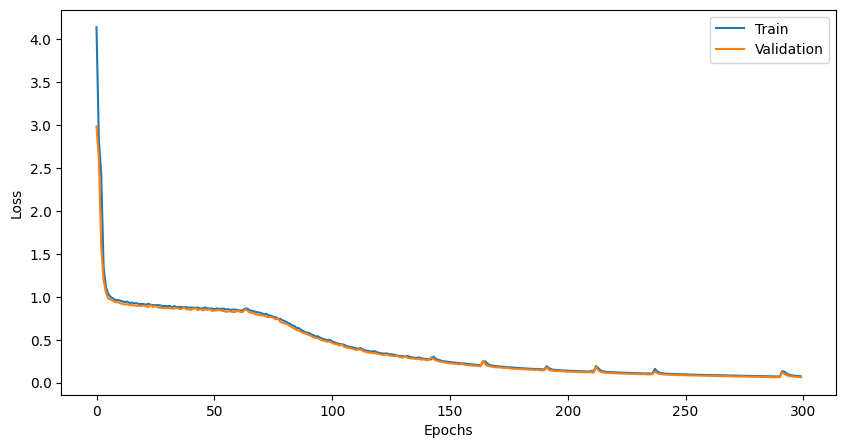

In [23]:
# 假设你已经训练好了模型并得到了 history
# model.plot_loss(history, path=None)  # 不保存图像时，可以传 None 或者不传 path 参数
model.plot_loss(history)

In [ ]:
# 假设你已经训练好了模型并得到了 history
model.plot_loss_kl(history, path=None)  # 不保存图像时，可以传 None 或者不传 path 参数

In [24]:
# 定义保存路径（保存模型的权重）
save_path = 'model_pre_weights1.h5'  # HDF5 格式保存权重文件

# 保存模型权重
model.save_weights(save_path)
print(f"模型权重已保存至 {save_path}")

模型权重已保存至 model_pre_weights1.h5


In [25]:
# 重新加载模型
# 创建虚拟数据以构建模型
seq_length = model.seq_length  # 模型定义的序列长度
batch_size = 1  # 用于测试的批次大小

# 创建三个输入:
# 1. X: SMILES序列
# 2. C: 两个条件SMILES序列拼接
# 3. L: 序列长度
dummy_data = (
    tf.zeros((batch_size, seq_length), dtype=tf.int32),  # X 
    tf.zeros((batch_size, seq_length * 2), dtype=tf.float32),  # C: 两个SMILES序列拼接
    tf.constant([seq_length], dtype=tf.int32)  # L
)

# 调用模型以完成构建
_ = model(dummy_data)

In [26]:
# 3. 加载权重
load_path = 'model_pre_weights1.h5'
model.load_weights(load_path)
print(f"模型权重已从 {load_path} 加载")

模型权重已从 model_pre_weights1.h5 加载


# 加载预训练权重，微调

In [ ]:
# import numpy as np
# import tensorflow as tf
# import time
# import matplotlib.pyplot as plt

# def transfer_vocab_weights(old_vocab, new_vocab, old_embedding_weights):
#     """
#     将预训练模型的嵌入层权重转移到新的词汇表上
    
#     Args:
#         old_vocab: 预训练模型的词汇表字典
#         new_vocab: 新数据集的词汇表字典
#         old_embedding_weights: 预训练模型的嵌入层权重
    
#     Returns:
#         new_embedding_weights: 新的嵌入层权重
#     """
#     # 获取嵌入维度
#     embedding_dim = old_embedding_weights.shape[1]
    
#     # 初始化新的嵌入权重
#     new_embedding_weights = np.random.uniform(
#         low=-0.1, 
#         high=0.1, 
#         size=(len(new_vocab), embedding_dim)
#     ).astype(np.float32)
    
#     # 统计重叠词汇
#     overlap_count = 0
    
#     # 对于重叠的词汇，复制预训练权重
#     for token, new_idx in new_vocab.items():
#         if token in old_vocab:
#             old_idx = old_vocab[token]
#             new_embedding_weights[new_idx] = old_embedding_weights[old_idx]
#             overlap_count += 1
    
#     print(f"词汇表重叠统计:")
#     print(f"  预训练词汇表大小: {len(old_vocab)}")
#     print(f"  新词汇表大小: {len(new_vocab)}")
#     print(f"  重叠词汇数量: {overlap_count}")
#     print(f"  重叠比例: {overlap_count/len(new_vocab)*100:.2f}%")
    
#     return new_embedding_weights

# def load_and_fine_tune_model(old_vocab, new_vocab, pretrained_weights_path,
#                              X_sample, C_sample, L_sample, X_new_sample, C_new_sample, L_new_sample):
#     """
#     1. 实例化旧模型并“构建”变量
#     2. 加载 H5 权重
#     3. 实例化新模型并“构建”变量
#     4. 迁移嵌入层权重 + 冻结/释放层
#     5. 返回新模型
#     """
#     # --- 1. 构建旧模型并创建变量 ---
#     old_model = Model(vocab=old_vocab)
#     # 假跑一次，确保 subclassed Model 的所有权重都创建好了
#     _ = old_model((X_sample, C_sample, L_sample), training=True)
    
#     # --- 2. 加载预训练权重 ---
#     old_model.load_weights(pretrained_weights_path)
#     print("✅ 旧模型权重加载完成")

#     # 提取旧 embedding 权重
#     old_embedding_weights = old_model.embedding.get_weights()[0]

#     # --- 3. 构建新模型并创建变量 ---
#     new_model = Model(vocab=new_vocab)
#     _ = new_model((X_new_sample, C_new_sample, L_new_sample), training=True)

#     # --- 4. 迁移嵌入层权重 ---
#     new_emb_w = transfer_vocab_weights(old_vocab, new_vocab, old_embedding_weights)
#     new_model.embedding.set_weights([new_emb_w])
#     print("✅ 嵌入层权重迁移完成")

#     # --- 5. 加载其余共享层权重 ---
#     try:
#         new_model.encoder.set_weights(old_model.encoder.get_weights())
#         print("✅ Encoder 权重加载完成")
#     except ValueError as e:
#         print(f"⚠️ 警告: 无法迁移所有的encoder权重: {str(e)}")
#         print("Proceeding with partial weight transfer...")
    
#     # --- 5.1 迁移 decoder 中间层（逐层迁移，跳过输出层） ---
#     # for old_layer, new_layer in zip(old_model.decoder.layers, new_model.decoder.layers):
#     #     try:
#     #         new_layer.set_weights(old_layer.get_weights())
#     #         print(f"✅ 迁移 decoder 子层：{new_layer.name}")
#     #     except ValueError:
#     #         print(f"⚠️ 跳过不兼容的 decoder 子层：{new_layer.name}")
#     #     print("✅ Decoder 中间层权重已迁移（不包括输出层）")
#     # --- 6. Transfer decoder weights (excluding output layer) ---
#     for old_layer, new_layer in zip(old_model.decoder.layers, new_model.decoder.layers):
#         if isinstance(new_layer, tf.keras.layers.Dense) and new_layer.units == new_model.vocab_size:
#             print(f"⚠️ 跳过输出层: {new_layer.name}")
#             continue
#         try:
#             new_layer.set_weights(old_layer.get_weights())
#             print(f"✅ 迁移 decoder 层: {new_layer.name}")
#         except ValueError as e:
#             print(f"⚠️ 警告: 无法迁移decoder层 {new_layer.name}: {str(e)}")# 这个代码跟上边以上，都跳过了输出层


#     # --- 6. 冻结共享权重，仅微调嵌入与输出层 ---
#     # 冻结 encoder + quantizer + decoder
#     new_model.encoder.trainable = True
#     new_model.decoder.trainable = True

#     # 释放 embedding 和 decoder 最后一层（假设叫 `decoder.dense` 或 `output_layer`）
#     new_model.embedding.trainable = True
#     try:
#         new_model.decoder.dense.trainable = True
#     except:
#         # 如果你 decoder 输出层名字不同，请改为 new_model.decoder.output_layer
#         new_model.decoder.output_layer.trainable = True

#     return new_model

In [ ]:
# # 定义词汇表
# old_vocab = {'#': 0, '(': 1, ')': 2, '-': 3, '.': 4, '/': 5, '1': 6, '2': 7, '3': 8, '4': 9, '5': 10, '6': 11, '7': 12, '=': 13, 'B': 14, 'Br': 15, 'C': 16, 'Cl': 17, 'E': 18, 'F': 19, 'I': 20, 'N': 21, 'O': 22, 'P': 23, 'S': 24, 'X': 25, '[ Co +2]': 26, '[ Co +]': 27, '[ Cr ]': 28, '[ Fe ]': 29, '[ Ir +]': 30, '[ Ni +2]': 31, '[ Pd +2]': 32, '[ Pd +]': 33, '[ Rh +]': 34, '[ Rh ]': 35, '[ Ru +2]': 36, '[ Ru +]': 37, '[B-1]': 38, '[B-]': 39, '[BH3-]': 40, '[C@@H]': 41, '[C@@]': 42, '[C@H]': 43, '[C@]': 44, '[C]': 45, '[H]': 46, '[K+]': 47, '[N+]': 48, '[N-1]': 49, '[N-]': 50, '[NH3+]': 51, '[N]': 52, '[Na+]': 53, '[O-1]': 54, '[O-]': 55, '[P+]': 56, '[P@@]': 57, '[P@H]': 58, '[P@]': 59, '[PH+]': 60, '[PH]': 61, '[S@@]': 62, '[S@]': 63, '[Si]': 64, '[c-]': 65, '[n+]': 66, '[nH]': 67, '\\': 68, 'c': 69, 'n': 70, 'o': 71, 'p': 72, 's': 73}

# new_vocab = {
#     '(': 0, ')': 1, '*': 2, '-': 3, '.': 4, '/': 5, '1': 6, '2': 7, '3': 8,
#     '4': 9, '=': 10, 'Br': 11, 'C': 12, 'Cl': 13, 'E': 14, 'F': 15,
#     'N': 16, 'O': 17, 'P': 18, 'S': 19, 'X': 20, 'c': 21, '5': 22
# }


In [27]:
seq_len = 165  # 必须与预训练一致
cond_dim = 2   # 从报错中看你用的是 shape=(1, 2)
X = tf.constant([[0]*seq_len], dtype=tf.int32)
C = tf.constant([[0.0]*cond_dim], dtype=tf.float32)
L = tf.constant([seq_len], dtype=tf.int32)  # batch_size=1

model((X, C, L))  # ✅ 现在提供三个输入
model.load_weights('model_pre_weights1.h5')
print(f"模型权重已从 {load_path} 加载")

模型权重已从 model_pre_weights1.h5 加载


In [28]:
# 新数据，新vocab映射
def load_new_vocab(file, args):
    """
    Load new_vocabulary and labels，并添加智能分词功能
    """
    f = open(file)
    lines = f.read().split('\n')[:-1]
    lines = [l.split() for l in lines]
    lines = [l for l in lines]
    labels = [l[1:] for l in lines][1:]

    if args.grammar == 'smiles':
        new_vocab={'#': 0, '(': 1, ')': 2, '-': 3, '.': 4, '/': 5, '1': 6, '2': 7, '3': 8, '4': 9, '5': 10, '6': 11, '7': 12, '=': 13, 'B': 14, 'Br': 15, 'C': 16, 'Cl': 17, 'E': 18, 'F': 19, 'I': 20, 'N': 21, 'O': 22, 'P': 23, 'S': 24, 'X': 25, '[ Co +2]': 26, '[ Co +]': 27, '[ Cr ]': 28, '[ Fe ]': 29, '[ Ir +]': 30, '[ Ni +2]': 31, '[ Pd +2]': 32, '[ Pd +]': 33, '[ Rh +]': 34, '[ Rh ]': 35, '[ Ru +2]': 36, '[ Ru +]': 37, '[B-1]': 38, '[B-]': 39, '[BH3-]': 40, '[C@@H]': 41, '[C@@]': 42, '[C@H]': 43, '[C@]': 44, '[C]': 45, '[H]': 46, '[K+]': 47, '[N+]': 48, '[N-1]': 49, '[N-]': 50, '[NH3+]': 51, '[N]': 52, '[Na+]': 53, '[O-1]': 54, '[O-]': 55, '[P+]': 56, '[P@@]': 57, '[P@H]': 58, '[P@]': 59, '[PH+]': 60, '[PH]': 61, '[S@@]': 62, '[S@]': 63, '[Si]': 64, '[c-]': 65, '[n+]': 66, '[nH]': 67, '\\': 68, 'c': 69, 'n': 70, 'o': 71, 'p': 72, 's': 73,'*': 74}                
        
        # 添加无空格版本的金属元素token
        for token, idx in list(new_vocab.items()):
            if isinstance(token, str) and token.startswith('[') and ' ' in token:
                no_space_token = token.replace(' ', '')
                if no_space_token not in new_vocab:
                    new_vocab[no_space_token] = idx
    else:
        raise ValueError("Unknown grammar type")
    
    chars = list(new_vocab)
    chars += ('E',)  # End of smiles末尾添加 E
    chars += ('X',)  # Start of smiles开头添加 X
    
    # 定义SMILES分词函数
    def tokenize(smiles):
        tokens = []
        i = 0
        smiles = smiles.strip()
        while i < len(smiles):
            # 优先匹配方括号里的整个 token
            if smiles[i] == '[':
                m = re.match(r"\[[^\[\]]+\]", smiles[i:])
                if m:
                    tok = m.group(0)
                    tokens.append(tok)
                    i += len(tok)
                    continue
            # 尝试两字符 token（如 Cl、Br）
            if i + 1 < len(smiles) and smiles[i:i+2] in new_vocab:
                tokens.append(smiles[i:i+2])
                i += 2
                continue
            # 单字符 token
            if smiles[i] in new_vocab:
                tokens.append(smiles[i])
                i += 1
                continue
            # 未知字符，打 warning 并跳过
            print(f"警告: '{smiles[i]}' 不在词汇表中。")
            i += 1
        return tokens
    
    # token 列表 → 索引列表
    def map_tokens_to_ids(tokens):
        return [new_vocab.get(tok, new_vocab['X']) for tok in tokens]

    return new_vocab, chars, labels, tokenize, map_tokens_to_ids

In [29]:
import pandas as pd
import torch
def load_and_map_new_smiles(file, args):
    """
    读取 CSV 文件并将 SMILES 映射为符号序列，同时计算每个 SMILES 对应的分子量
    支持 Sub1 和 Sub2 两个替代分子列
    """
    # 读取 CSV
    df = pd.read_csv(file)
    smiles_list = df['SMILES'].tolist()
    
    # 加载词表和字符、标签信息以及分词函数
    new_vocab, chars, labels, tokenize, map_tokens_to_ids = load_new_vocab(file, args)
    
    # 将主 SMILES 映射为符号序列
    sequences = []
    for smiles in smiles_list:
        tokens = tokenize(smiles)
        ids = map_tokens_to_ids(tokens)
        # 填充序列到统一长度
        max_len = 165  # 或者其他您想要的长度
        ids += [new_vocab['E']] * (max_len - len(ids))
        sequences.append(ids)
    
    # 计算每个 SMILES 的分子对象列表（可用于分子量等计算）
    mols = mol_from_smiles(smiles_list)
    
    # 读取 Sub1、Sub2 和 OUTPUT
    sub1_sequences, sub2_sequences, output_values = None, None, None
    if {'Sub1', 'Sub2', 'OUTPUT'}.issubset(df.columns):
        sub1_list = df['Sub1'].tolist()
        sub2_list = df['Sub2'].tolist()
        output_values = df['OUTPUT'].tolist()
        
        # 映射 Sub1 和 Sub2
        sub1_sequences = []
        for smiles in sub1_list:
            tokens = tokenize(smiles)
            ids = map_tokens_to_ids(tokens)
            ids += [new_vocab['E']] * (max_len - len(ids))
            sub1_sequences.append(ids)
            
        sub2_sequences = []
        for smiles in sub2_list:
            tokens = tokenize(smiles)
            ids = map_tokens_to_ids(tokens)
            ids += [new_vocab['E']] * (max_len - len(ids))
            sub2_sequences.append(ids)
    else:
        missing = [col for col in ['Sub1', 'Sub2', 'OUTPUT'] if col not in df.columns]
        print(f"警告: CSV文件中缺少列: {', '.join(missing)}")

    # 转为 PyTorch Tensor
    sequences_tensor = torch.tensor(sequences, dtype=torch.long)

    # 返回主 SMILES 列表、主序列 Tensor、Sub1 、Sub2 、OUTPUT 值列表以及字符表
    return smiles_list, sequences_tensor, sub1_sequences, sub2_sequences, output_values, chars

In [30]:
# 示例调用
args = type('', (), {})()
args.grammar = 'smiles'

# 加载数据
new_smiles_list, new_sequences_tensor, new_sub1_seq, new_sub2_seq, new_output_values, new_chars = load_and_map_new_smiles('reactions_5.csv', args)

# 划分训练和测试集
(train_new_smiles, test_new_smiles,
 train_new_seq, test_new_seq,
 train_new_sub1, test_new_sub1,
 train_new_sub2, test_new_sub2,
 train_new_output, test_new_output) = split_data(
    new_smiles_list, new_sequences_tensor,
    new_sub1_seq, new_sub2_seq,
    new_output_values,
    test_ratio=0.2
)

# # # 输出示例
# # print(f"训练集大小: {len(train_smiles)}, 测试集大小: {len(test_smiles)}")
# # for i in range(min(5, len(train_smiles))):
# #     print(f"SMILES: {train_smiles[i]}, 主序列: {train_seq[i]}, Sub1序列: {train_sub1[i]}, Sub2序列: {train_sub2[i]}, OUTPUT: {train_output[i]}")

In [31]:
# 假设 seq_length 是序列的最大长度
new_seq_length = train_new_seq.shape[1]

# 将替代序列和输出转换为 numpy 数组
train_new_sub1_arr = np.array(train_new_sub1, dtype=np.int32)  # (N, L_sub)
train_new_sub2_arr = np.array(train_new_sub2, dtype=np.int32)  # (N, L_sub)
test_new_sub1_arr  = np.array(test_new_sub1,  dtype=np.int32)  # (M, L_sub)
test_new_sub2_arr  = np.array(test_new_sub2,  dtype=np.int32)  # (M, L_sub)

# 横向拼接 sub1, sub2, output
C_new_train_np = np.hstack((train_new_sub1_arr, train_new_sub2_arr))  # (N, 2*L_sub+1)
C_new_val_np   = np.hstack((test_new_sub1_arr,  test_new_sub2_arr))   # (M, 2*L_sub+1)

# 转成 TensorFlow 张量
C_new_train = tf.convert_to_tensor(C_new_train_np, dtype=tf.float32)
C_new_val   = tf.convert_to_tensor(C_new_val_np,   dtype=tf.float32)
# --------- 修改 END ---------

# X/Y/L 输入保持不变
X_new_train = train_new_seq
Y_new_train = train_new_seq
L_new_train = np.full((len(train_new_seq),), new_seq_length, dtype=np.int32)

X_new_val = test_new_seq
Y_new_val = test_new_seq
L_new_val = np.full((len(test_new_seq),), new_seq_length, dtype=np.int32)

print(f"X_new_train: {X_new_train.shape}, C_new_train: {C_new_train.shape}")
print(f"X_new_val:   {X_new_val.shape},   C_new_val:   {C_new_val.shape}")

X_new_train: torch.Size([7360, 165]), C_new_train: (7360, 330)
X_new_val:   torch.Size([1840, 165]),   C_new_val:   (1840, 330)


In [32]:
import tensorflow as tf
import torch
import time

# Y_train = tf.convert_to_tensor(Y_train, dtype=tf.string)
Y_new_train = tf.convert_to_tensor(Y_new_train.numpy(), dtype=tf.int32)
C_new_train = tf.convert_to_tensor(C_new_train, dtype=tf.float32)
L_new_train = tf.convert_to_tensor(L_new_train, dtype=tf.int32)
Y_new_val = tf.convert_to_tensor(Y_new_val.numpy(), dtype=tf.int32)
C_new_val = tf.convert_to_tensor(C_new_val, dtype=tf.float32)
L_new_val = tf.convert_to_tensor(L_new_val, dtype=tf.int32)

X_new_train = tf.convert_to_tensor(X_new_train.numpy(), dtype=tf.int32)  # 确保是整数类型
X_new_val = tf.convert_to_tensor(X_new_val.numpy(), dtype=tf.int32)

In [34]:
# # 假设已经有 old_vocab, new_vocab, 以及 X_train, C_train, L_train
# X_s, C_s, L_s = X_train[:1], C_train[:1], L_train[:1]
# X_new_s, C_new_s, L_new_s = X_new_train[:1], C_new_train[:1], L_new_train[:1]

# model = load_and_fine_tune_model(
#     old_vocab, new_vocab, 'model_allgen_ mmd_weights17.h5',
#     X_sample=X_s, C_sample=C_s, L_sample=L_s,
#     X_new_sample=X_new_s, C_new_sample=C_new_s, L_new_sample=L_new_s,
# )

# # 验证模型已就绪
# print("新模型可训练参数：")
# for layer in [model.embedding, model.decoder.dense]:
#     print(layer.name, "trainable:", layer.trainable)
# for layer in [model.encoder, model.decoder]:
#     print(layer.name, "trainable:", layer.trainable)

# 然后就可以直接微调了：
history = model.train(
    dataset_train=(X_new_train, Y_new_train, C_new_train, L_new_train),
    dataset_val  =(X_new_val,   Y_new_val,   C_new_val,   L_new_val),
    epochs=10,
    patience=5
)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10, loss: 0.3005, reconstruction: 0.1992, mmd_loss: 0.0924, Regularization: 0.0090, loss_val: 0.1564, reconstruction_val: 0.1179, mmd_loss_val: 0.0385, Time: 6.02s
Epoch: 2/10, loss: 0.1311, reconstruction: 0.0986, mmd_loss: 0.0235, Regularization: 0.0090, loss_val: 0.0992, reconstruction_val: 0.0798, mmd_loss_val: 0.0195, Time: 5.64s
Epoch: 3/10, loss: 0.0956, reconstruction: 0.0703, mmd_loss: 0.0163, Regularization: 0.0090, loss_val: 0.0734, reconstruction_val: 0.0604, mmd_loss_val: 0.0131, Time: 5.77s
Epoch: 4/10, loss: 0.0742, reconstruction: 0.0539, mmd_loss: 0.0113, Regularization: 0.0090, loss_val: 0.0579, reconstruction_val: 0.0472, mmd_loss_val: 0.0107, Time: 5.46s
Epoch: 5/10, loss: 0.0630, reconstruction: 0.0434, mmd_loss: 0.0107, Regularization: 0.0090, loss_val: 0.0499, reconstruction_val: 0.0402, mmd_loss_val: 0.0097, Time: 5.26s
Epoch: 6/10, loss: 0.0570, reconstruction: 0.0382, mmd_loss: 0.0099, Regularization: 0.0090, loss_val: 0.0462, reconstruction_val: 0.03

In [35]:
# 定义保存路径（保存模型的权重）
save_path = 'NOTLmodel_weights1.h5'  # HDF5 格式保存权重文件

# 保存模型权重
model.save_weights(save_path)
print(f"模型权重已保存至 {save_path}")

模型权重已保存至 NOTLmodel_weights1.h5


In [36]:
# 重新加载模型
# 创建虚拟数据以构建模型
seq_length = model.seq_length  # 模型定义的序列长度
batch_size = 1  # 用于测试的批次大小

# 创建三个输入:
# 1. X: SMILES序列
# 2. C: 两个条件SMILES序列拼接
# 3. L: 序列长度
dummy_data = (
    tf.zeros((batch_size, seq_length), dtype=tf.int32),  # X 
    tf.zeros((batch_size, seq_length * 2), dtype=tf.float32),  # C: 两个SMILES序列拼接
    tf.constant([seq_length], dtype=tf.int32)  # L
)

# 调用模型以完成构建
_ = model(dummy_data)

In [37]:
# 3. 加载权重
load_path = 'NOTLmodel_weights1.h5'
model.load_weights(load_path)
print(f"模型权重已从 {load_path} 加载")
# # 2. 重新定义优化器（如果需要）
# model.optimizer = tf.keras.optimize1rs.Adam(learning_rate=model.lr)

# 然后就可以直接微调了：
history = model.train(
    dataset_train=(X_new_train, Y_new_train, C_new_train, L_new_train),
    dataset_val  =(X_new_val,   Y_new_val,   C_new_val,   L_new_val),
    epochs=190,
    patience=50
)
 
print("模型训练完成！")

模型权重已从 NOTLmodel_weights1.h5 加载


Epochs:   0%|          | 0/190 [00:00<?, ?it/s]

Epoch: 1/190, loss: 0.0472, reconstruction: 0.0291, mmd_loss: 0.0091, Regularization: 0.0090, loss_val: 0.0391, reconstruction_val: 0.0288, mmd_loss_val: 0.0103, Time: 5.96s
Epoch: 2/190, loss: 0.0461, reconstruction: 0.0280, mmd_loss: 0.0091, Regularization: 0.0090, loss_val: 0.0369, reconstruction_val: 0.0276, mmd_loss_val: 0.0093, Time: 5.65s
Epoch: 3/190, loss: 0.0447, reconstruction: 0.0270, mmd_loss: 0.0087, Regularization: 0.0090, loss_val: 0.0354, reconstruction_val: 0.0268, mmd_loss_val: 0.0086, Time: 5.59s
Epoch: 4/190, loss: 0.0440, reconstruction: 0.0263, mmd_loss: 0.0088, Regularization: 0.0090, loss_val: 0.0357, reconstruction_val: 0.0266, mmd_loss_val: 0.0092, Time: 5.82s
Epoch: 5/190, loss: 0.0434, reconstruction: 0.0257, mmd_loss: 0.0087, Regularization: 0.0090, loss_val: 0.0341, reconstruction_val: 0.0253, mmd_loss_val: 0.0088, Time: 5.69s
Epoch: 6/190, loss: 0.0425, reconstruction: 0.0248, mmd_loss: 0.0087, Regularization: 0.0090, loss_val: 0.0342, reconstruction_val

In [39]:
# 定义保存路径（保存模型的权重）
save_path = 'NOTLmodel_weights1.h5'  # HDF5 格式保存权重文件

# 保存模型权重
model.save_weights(save_path)
print(f"模型权重已保存至 {save_path}")

模型权重已保存至 NOTLmodel_weights1.h5


# 根据generate函数生成分子

In [40]:
def convert_to_smiles(vector, char):
    """
    Convert a vector to a SMILES string
    """
    list_char = list(char)
    try:
        vector = vector.numpy()
    except AttributeError:
        pass  # already a NumPy array
    vector = vector.astype(int)
    return "".join(map(lambda x: list_char[x], vector)).strip()



In [41]:
def prepare_condition(sub1, sub2, vocab, max_len, tokenize, map_tokens_to_ids):
    """
    将两个 SMILES (sub1, sub2) 转换为拼接后的 token 条件向量 C
    """
    # Tokenize 并转 ID
    tokens1 = tokenize(sub1)
    ids1 = map_tokens_to_ids(tokens1)
    ids1 += [vocab['E']] * (max_len - len(ids1))  # padding

    tokens2 = tokenize(sub2)
    ids2 = map_tokens_to_ids(tokens2)
    ids2 += [vocab['E']] * (max_len - len(ids2))

    ids1_arr = np.array(ids1, dtype=np.int32)  # (N, L_sub)
    ids2_arr = np.array(ids2, dtype=np.int32)  # (N, L_sub)

    # 拼接两个序列
    C = np.hstack((ids1_arr, ids2_arr))  # (N, 2*L_sub+1)
    
    return C


In [42]:
def generate_molecules(model, sub1, sub2, vocab, chars, tokenize, map_tokens_to_ids, num_samples=10, max_length=100):
    """
    基于给定的底物SMILES生成新分子
    
    参数:
    model: 训练好的CVAE模型
    substrate_smiles: 底物SMILES字符串
    vocab: 词汇表字典
    inv_vocab: 反向词汇表字典
    num_samples: 要生成的分子数量
    max_length: 最大序列长度
    
    返回:
    生成的SMILES列表
    """
    # 将底物SMILES转换为序列
    C = prepare_condition(sub1, sub2, vocab, max_length, tokenize, map_tokens_to_ids)
    
    C = np.tile(C, (num_samples, 1))  # 复制num_samples次
    
    # 创建起始标记（使用'X'作为开始标记）
    start_codon = np.array([[vocab['X']]] * num_samples)  # shape: (10, 1)
   
    # 生成分子
    generated_tensors = model.generate(C, start_codon)
   
    # 将生成的张量转换回SMILES
    generated_smiles = []
    for tensor in generated_tensors:
        token_ids = tensor.numpy()

        # 找到第一个'E'的位置
        try:
            end_idx = np.where(token_ids == vocab['E'])[0][0]
            # 截断到'E'之前
            token_ids = token_ids[:end_idx]
        except IndexError:
            # 如果没有找到'E'，使用整个序列
            pass

        # 跳过空序列
        if len(token_ids) == 0:
            continue
            
        smiles = convert_to_smiles(token_ids, chars)
       
        # 验证生成的SMILES是否有效
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            generated_smiles.append(smiles)
    
    return generated_smiles

In [ ]:
# 加载模型
load_path = 'model_pre_weights1.h5'
model.load_weights(load_path)
print(f"模型权重已从 {load_path} 加载")

sub1 = "CCOC(=O)/C=C(\C)c1ccccc1.ClCCl"
sub2 = "[Ir+]"

# 生成分子
generated_molecules = generate_molecules(
    model.decoder, 
    sub1,
    sub2, 
    vocab, 
    chars,
    tokenize,
    map_tokens_to_ids,
    num_samples=100
)

# 打印生成的分子
print("\nGenerated molecules:")
for i, smiles in enumerate(generated_molecules, 1):
    print(f"{i}. {smiles}")

# 保存到 CSV 文件
output_file = "generate_SMILES17.csv"
df = pd.DataFrame({'Generated_SMILES': generated_molecules})
df.to_csv(output_file, index=False)

print(f"\nGenerated {len(generated_molecules)} valid molecules.")
print(f"Results saved to {output_file}")

# 根据generate_random_sample函数生成分子

In [44]:
# random_sample函数
def generate_random_molecules(model, sub1, sub2, vocab, chars, tokenize, map_tokens_to_ids, num_samples=100, max_length=165):
    """
    基于给定底物 SMILES 生成新分子。
    """
    C = prepare_condition(sub1, sub2, vocab, max_length, tokenize, map_tokens_to_ids)
    C = np.tile(C, (num_samples, 1))  # shape: [num_samples, cond_dim]

    start_codon = np.array([[vocab['X']]] * num_samples)  # shape: [num_samples, 1]
    stop_token_id = vocab['E']

    # 调用 model 的方法生成
    smiles_list = model.decoder.generate_random_sample(C, start_codon, chars, max_len=max_length, return_smiles=True, stop_token_id=stop_token_id)
    return smiles_list


In [45]:
def generate_topk_molecules(model, sub1, sub2, vocab, chars, tokenize, map_tokens_to_ids, k=5, num_samples=100, max_length=165):
    """
    基于给定底物 SMILES 使用 Top-k 采样生成新分子。
    
    Args:
        model: 训练好的模型
        sub1, sub2: 底物SMILES字符串
        vocab: 词汇表字典
        chars: token列表
        tokenize: 分词函数
        map_tokens_to_ids: token到ID的映射函数
        k: Top-k采样的k值，只考虑概率最高的k个token
        num_samples: 生成的分子数量
        max_length: 最大序列长度
    
    Returns:
        生成的SMILES字符串列表
    """
    C = prepare_condition(sub1, sub2, vocab, max_length, tokenize, map_tokens_to_ids)
    C = np.tile(C, (num_samples, 1))  # shape: [num_samples, cond_dim]

    start_codon = np.array([[vocab['X']]] * num_samples)  # shape: [num_samples, 1]
    stop_token_id = vocab['E']

    # 调用 model 的方法生成
    smiles_list = model.decoder.generate_topk_sampling(C, start_codon, chars, k=k, max_len=max_length, return_smiles=True, stop_token_id=stop_token_id)
    return smiles_list

In [46]:
def generate_topp_molecules(model, sub1, sub2, vocab, chars, tokenize, map_tokens_to_ids, p=0.95, num_samples=100, max_length=165):
    """
    基于给定底物 SMILES 使用 Top-p (nucleus) 采样生成新分子。
    
    Args:
        model: 训练好的模型
        sub1, sub2: 底物SMILES字符串
        vocab: 词汇表字典
        chars: token列表
        tokenize: 分词函数
        map_tokens_to_ids: token到ID的映射函数
        p: Top-p采样的概率阈值，累积概率达到p时截断
        num_samples: 生成的分子数量
        max_length: 最大序列长度
    
    Returns:
        生成的SMILES字符串列表
    """
    C = prepare_condition(sub1, sub2, vocab, max_length, tokenize, map_tokens_to_ids)
    C = np.tile(C, (num_samples, 1))  # shape: [num_samples, cond_dim]

    start_codon = np.array([[vocab['X']]] * num_samples)  # shape: [num_samples, 1]
    stop_token_id = vocab['E']

    # 调用 model 的方法生成
    smiles_list = model.decoder.generate_topp_sampling(C, start_codon, chars, p=p, max_len=max_length, return_smiles=True, stop_token_id=stop_token_id)
    return smiles_list

In [47]:
# 使用示例代码
def test_different_sampling_methods():
    """
    测试不同采样方法的示例代码
    """
    # 假设这些已经准备好了
    sub1 = "CCOC(=O)/C=C(\C)c1ccccc1.ClCCl"
    sub2 = "[Ir+]"
    num_samples = 100
    max_length = 165
    
    # 创建字符映射
    chars = [None] * len(vocab)
    for k, v in vocab.items():
        chars[v] = k
    
    print("=== 原始随机采样 ===")
    random_smiles = generate_random_molecules(model, sub1, sub2, vocab, chars, tokenize, map_tokens_to_ids,
                                            num_samples=num_samples, max_length=max_length)
    for i, smi in enumerate(random_smiles):
        print(f"{i+1}: {smi}")
    
    print("\n=== Top-k 采样 (k=5) ===")
    topk_smiles = generate_topk_molecules(model, sub1, sub2, vocab, chars, tokenize, map_tokens_to_ids,
                                        k=5, num_samples=num_samples, max_length=max_length)
    for i, smi in enumerate(topk_smiles):
        print(f"{i+1}: {smi}")
    
    print("\n=== Top-p 采样 (p=0.9) ===")
    topp_smiles = generate_topp_molecules(model, sub1, sub2, vocab, chars, tokenize, map_tokens_to_ids,
                                        p=0.9, num_samples=num_samples, max_length=max_length)
    for i, smi in enumerate(topp_smiles):
        print(f"{i+1}: {smi}")
    
    # 保存结果到不同的CSV文件  
    pd.DataFrame({'Random_Sampling': random_smiles}).to_csv('random_sampling_results.csv', index=False)
    pd.DataFrame({'TopK_Sampling': topk_smiles}).to_csv('topk_sampling_results.csv', index=False)
    pd.DataFrame({'TopP_Sampling': topp_smiles}).to_csv('topp_sampling_results.csv', index=False)
    
    print(f"\n生成结果已保存到CSV文件")
    print(f"随机采样: {len(random_smiles)} 个有效分子")
    print(f"Top-k采样: {len(topk_smiles)} 个有效分子")
    print(f"Top-p采样: {len(topp_smiles)} 个有效分子")

In [48]:
# 加载模型
load_path = 'model_pre_weights1.h5'  
model.load_weights(load_path)

# 执行测试
test_different_sampling_methods()

=== 原始随机采样 ===


[19:30:30] SMILES Parse Error: syntax error while parsing: cCl\[B-][
[19:30:30] SMILES Parse Error: Failed parsing SMILES 'cCl\[B-][' for input: 'cCl\[B-]['
[19:30:30] SMILES Parse Error: syntax error while parsing: 1[NH3+][
[19:30:30] SMILES Parse Error: Failed parsing SMILES '1[NH3+][' for input: '1[NH3+]['
[19:30:30] SMILES Parse Error: syntax error while parsing: [C@][
[19:30:30] SMILES Parse Error: Failed parsing SMILES '[C@][' for input: '[C@]['
[19:30:30] SMILES Parse Error: syntax error while parsing: [
[19:30:30] SMILES Parse Error: Failed parsing SMILES '[' for input: '['
[19:30:30] SMILES Parse Error: syntax error while parsing: [P@]c1S[
[19:30:30] SMILES Parse Error: Failed parsing SMILES '[P@]c1S[' for input: '[P@]c1S['
[19:30:30] SMILES Parse Error: syntax error while parsing: [C@H]X[PH+]NO[P+]6O[
[19:30:30] SMILES Parse Error: Failed parsing SMILES '[C@H]X[PH+]NO[P+]6O[' for input: '[C@H]X[PH+]NO[P+]6O['
[19:30:30] SMILES Parse Error: extra open parentheses for input: '[


=== Top-k 采样 (k=5) ===


[19:30:34] SMILES Parse Error: duplicated ring closure 2 bonds atom 4 to itself for input: '[C@H]cn[C@H]p222[C@@H][C@@H]4[C@@H]4n[C@H][C@@H]4424[C@@H][C@H]nncccccc[C@@H]c[C@@H]ncn4s442222O3=OO=2[C@@H][C@H]cc45sP[C@H]cc4s24occ[C@H]c22o4423424ns423O4c'
[19:30:34] SMILES Parse Error: syntax error while parsing: 1(CC[
[19:30:34] SMILES Parse Error: Failed parsing SMILES '1(CC[' for input: '1(CC['
[19:30:34] SMILES Parse Error: extra close parentheses while parsing: O[Si]=OO1O)11=))(((1FFO)(([
[19:30:34] SMILES Parse Error: Failed parsing SMILES 'O[Si]=OO1O)11=))(((1FFO)(([' for input: 'O[Si]=OO1O)11=))(((1FFO)((['
[19:30:34] SMILES Parse Error: extra close parentheses while parsing: [C@@H]ccnn233))[
[19:30:34] SMILES Parse Error: Failed parsing SMILES '[C@@H]ccnn233))[' for input: '[C@@H]ccnn233))['
[19:30:34] SMILES Parse Error: syntax error while parsing: F=)1OS=1=OON22O1[
[19:30:34] SMILES Parse Error: Failed parsing SMILES 'F=)1OS=1=OON22O1[' for input: 'F=)1OS=1=OON22O1['
[19:30:34] S


=== Top-p 采样 (p=0.9) ===
1: [P@@]
2: Cl[B-]CB

生成结果已保存到CSV文件
随机采样: 0 个有效分子
Top-k采样: 0 个有效分子
Top-p采样: 2 个有效分子


[19:30:38] SMILES Parse Error: syntax error while parsing: n#.-[B-][Na+]4[C@@][nH]o[Si][H][S@@]oXBrOn[PH+][Na+][
[19:30:38] SMILES Parse Error: Failed parsing SMILES 'n#.-[B-][Na+]4[C@@][nH]o[Si][H][S@@]oXBrOn[PH+][Na+][' for input: 'n#.-[B-][Na+]4[C@@][nH]o[Si][H][S@@]oXBrOn[PH+][Na+]['
[19:30:38] SMILES Parse Error: syntax error while parsing: .6.[
[19:30:38] SMILES Parse Error: Failed parsing SMILES '.6.[' for input: '.6.['
[19:30:38] SMILES Parse Error: syntax error while parsing: B[O-1][C@H][BH3-][B-][O-1]=[
[19:30:38] SMILES Parse Error: Failed parsing SMILES 'B[O-1][C@H][BH3-][B-][O-1]=[' for input: 'B[O-1][C@H][BH3-][B-][O-1]=['
[19:30:38] SMILES Parse Error: syntax error while parsing: [P+][C@@H][
[19:30:38] SMILES Parse Error: Failed parsing SMILES '[P+][C@@H][' for input: '[P+][C@@H]['
[19:30:38] SMILES Parse Error: syntax error while parsing: \cs[
[19:30:38] SMILES Parse Error: Failed parsing SMILES '\cs[' for input: '\cs['
[19:30:38] SMILES Parse Error: syntax error while 

# 与核心片段拼接成完整的手性磷酸催化剂

In [49]:
import Fragment_processing

## 尝试在多个位点插入(*)
# 加载 SMILES 数据
# df_smiles_gen = pd.read_csv('unique_generated_smiles.csv')
smiles_gen_list = generated_smiles
# smiles_gen_list = df_smiles_gen['Generated_SMILES'].tolist()

# 定义核心结构
core_list = [
    "OP1(Oc2c(c3c(CCCC4)c4cc(*)c3O1)c(CCCC5)c5cc2(*))=O",
    "OP1(Oc2c(c3c4ccccc4cc(*)c3O1)c5ccccc5cc2(*))=O",
    "OP1(Oc2c(*)cc3c(CCCC3)c2C4c5c(CC(C4O1)(*))cccc5)=O",
    "O=P1(Oc(cc2)c(c(c(O1)cc3)c4c3cc(*)cc4)c5c2cc(*)cc5)O",
]

# 生成片段库
frag_list = generate_fragment_library(smiles_gen_list)

# 生成多核心多片段组合
multi_results, core_indices = multi_core_multi_frag_join(core_list, frag_list, use_symmetric=True)

# 保存结果
# output_file = 'multi_core.csv'
# df = save_to_csv(multi_results, core_indices, core_list, output_file)

# print(f"已生成 {len(multi_results)} 个分子组合，并已保存到 {output_file}")
# 1. 从 multi_core.csv 读取生成的 SMILES
df_valid = multi_results
df_valid = pd.read_csv('multi_core.csv')
if 'SMILES' not in df_valid.columns:
    raise KeyError("multi_core.csv 中未找到 'SMILES' 列")
gen_smiles = df_valid['SMILES'].dropna().tolist()

# 2. 调用主处理流程：清理、验证、并保存 valid/invalid SMILES
valid_smiles, invalid_smiles = process_generated_smiles(gen_smiles)

# 打印一些统计信息
print("\n处理结果统计:")
print(f"总SMILES数量: {len(gen_smiles)}")
print(f"有效SMILES数量: {len(valid_smiles)}")
print(f"无效SMILES数量: {len(invalid_smiles)}")
# print(f"去重后SMILES数量: {len(final_smiles)}")

# 打印前5个有效SMILES
print("\n前5个有效SMILES:")
for i, smiles in enumerate(valid_smiles[:5]):
    print(f"{i+1}. {smiles}")
# 假设 valid_smiles 是生成的SMILES列表
# 假设 smiles_list 是初始输入的SMILES列表

# 1. 比较SMILES
# 加载 SMILES 数据
df_1075 = pd.read_csv('1075_cat.csv')  # 假设 'all_c.csv' 文件路径正确
smiles_list = df_1075['Catalyst'].tolist()  # 提取 Catalyst 列
results_df, results_unique_df, results_duplicate_df = compare_with_initial_smiles(valid_smiles, smiles_list)

# 2. 分析结果
total = len(results_df)
duplicates = results_df['Is_Duplicate'].sum()
unique = total - duplicates
print(f"唯一SMILES数量: {unique}")

NameError: name 'generated_smiles' is not defined

# 强化学习部分

# generate_random_sample对应的强化学习部分

In [68]:
import os
import sys
import pandas as pd
sys.path.append('./scscore15/scscore-master/scscore')
from standalone_model_numpy import SCScorer
from itertools import product
import Fragment_processing
import os
import sys
import torch
sys.path.append(os.path.abspath('MMHRP-GCL-Code-main'))
from utils.rxn import *
from utils.molecule import *
from torch_geometric.loader import DataLoader
from models.MMHRP_GCL import *
import time
from tqdm import tqdm
import datetime
import warnings
warnings.simplefilter('ignore')

# 封装一个surrogate_regressor模型，定义一个接口
class SurrogateRegressor:
    def __init__(self, smiles, reactant_combine):
        self.smiles = smiles 
        self.reactant_combine = 'O=C(/N=C/c1ccc(C(F)(F)F)cc1)c1ccccc1.CCS.CCSC(NC(=O)c1ccccc1)c1ccc(C(F)(F)F)cc1'
        
    def predictor(self, smiles, reactant_combine):
        """
        results_unique_df: 每个元素是完整催化剂的SMILES
        返回： (smiles, predicted_values_tensor)
        reactant_combine='O=C(/N=C/c1ccc(C(F)(F)F)cc1)c1ccccc1.CCS.CCSC(NC(=O)c1ccccc1)c1ccc(C(F)(F)F)cc1'
        """
        # 拆分 reactant_combine
        parts = reactant_combine.split('.')
        if len(parts) != 3:
            raise ValueError(f"reactant_combine 的格式应为 'Imine.Thiol.Product'，但现在得到 {len(parts)} 部分：{parts}")

        imine = parts[0]
        thiol = parts[1]
        product = parts[2]
        
        combinations = []
        for s in smiles:
            combined_smiles = f"{imine}.{thiol}.{product}.{s}"
            combinations.append({
                'Catalyst': s,
                'Imine': imine,
                'Thiol': thiol,
                'product': product
            })
        
        expanded_df = pd.DataFrame(combinations)
        new_data = expanded_df
        expanded_df.to_csv("Combinations.csv", index=False)
        
        def check_smiles_validity(smi):
            mol = Chem.MolFromSmiles(smi)
            return mol is not None
        
        valid_rows = []
        invalid_indices = []
        
        for idx, row in new_data.iterrows():
            smi_list = [row["Catalyst"], row["Imine"], row["Thiol"], row["product"]]
            if all(check_smiles_validity(smi) for smi in smi_list):
                valid_rows.append(row)
            else:
                invalid_indices.append(idx)
        
        # 重新构建合法数据 DataFrame
        new_data = pd.DataFrame(valid_rows).reset_index(drop=True)


        # 模型加载
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
       
        # 模型超参数（要和训练时一致！）
        num_feature = 8
        smi_inputsize = 128
        
        # vocab 文件路径
        vocab_type = "AT"
        vocab_path = "./MMHRP-GCL-Code-main/utils/%s_vocab.txt" % vocab_type
        
        # 模型保存路径
        model_path = "./MMHRP-GCL-Code-main/exp/AT/AT_MMHRP-GCL_rs=3/model.pth"
        
        # ---------------------- 加载模型 ----------------------
        model = MMHRP_GCL(
            GraphEncoder={
                "NodeFeatNum": num_feature,
                "Channels": [32, 64],
                "Heads": 4
            },
            TextEncoder={
                "SmiFeatNum": smi_inputsize,
                "Heads": 4,
                "BigruChannels": [128, 128, 128],
                "BigruNumlayer": 1
            },
            Decoder={
                "Heads": 4,
                "Channels": [1000, 500, 100]
            },
            device=device
        )
        
        model = torch.load(model_path, map_location=device)
        model = model.to(device)
        model.eval()
        print("模型已加载成功！")
        
        # 数据处理
        rxn_dataset = []
        rxn_RxnSmi = []
        max_len = -1
       
        # 确定max_len
        for idx in range(new_data.shape[0]):
            RxnSmi = get_AT_RxnSmi(new_data.iloc[idx, :])
            max_len = max(max_len, len(RxnSmi))
            RxnSmi = " ".join(smi_tokenizer(RxnSmi))
            rxn_RxnSmi.append(RxnSmi)
        
        # 构建数据集
        for idx in range(new_data.shape[0]):
            meta = []
            
            # 反应物-产物图
            rea1 = new_data.loc[idx]["Imine"]
            rea2 = new_data.loc[idx]["Thiol"]
            prod = new_data.loc[idx]["product"]
            rea_pro_graph = smis_to_graph([rea1, rea2, prod])
            # 确保节点特征维度正确
            if rea_pro_graph.x.size(1) != num_feature:
                rea_pro_graph.x = torch.nn.functional.pad(rea_pro_graph.x, (0, num_feature - rea_pro_graph.x.size(1)))
            meta.append(rea_pro_graph)
            
            # 催化剂图
            cat = new_data.loc[idx]["Catalyst"]
            cat_graph = smis_to_graph([cat])
            # 确保节点特征维度正确
            if cat_graph.x.size(1) != num_feature:
                cat_graph.x = torch.nn.functional.pad(cat_graph.x, (0, num_feature - cat_graph.x.size(1)))
            meta.append(cat_graph)
            
            # RxnSmi张量
            RxnSmi_vec = RxnSmi_to_tensor(
                RxnSmi=rxn_RxnSmi[idx],
                maxlen_=max_len,
                victor_size=smi_inputsize,
                file=vocab_path
            )
            meta.append(RxnSmi_vec)
            
            # 输出（如果存在）
            if "Output" in new_data.columns:
                meta.append(torch.tensor(new_data.loc[idx]["Output"], dtype=torch.float))
            
            rxn_dataset.append(meta)
        
        # 创建DataLoader
        test_loader = DataLoader(rxn_dataset, batch_size=1, shuffle=False)
        
        # 模型预测
        with torch.no_grad():
            predictions = []
            true_values = []
            
            for batch_data in test_loader:
                # 确保数据在正确的设备上
                ReaPro_data = batch_data[0].to(device)
                CatSol_data = batch_data[1].to(device)
                RxnSmi_data = batch_data[2].to(device)
                
                # 确保输入维度正确
                if ReaPro_data.x.size(1) != num_feature:
                    ReaPro_data.x = torch.nn.functional.pad(ReaPro_data.x, (0, num_feature - ReaPro_data.x.size(1)))
                if CatSol_data.x.size(1) != num_feature:
                    CatSol_data.x = torch.nn.functional.pad(CatSol_data.x, (0, num_feature - CatSol_data.x.size(1)))
                
                x = [ReaPro_data, CatSol_data, RxnSmi_data]
                pred = model.forward(x).cpu().detach().numpy()
                # predictions.extend(pred.tolist())#这个地方最后输出的是[]列表形式
                predictions.extend(pred.flatten().tolist())#这样输出的就是数字形式
                
                if len(batch_data) == 4:
                    true = batch_data[3].detach().numpy()
                    true_values.extend(true.tolist())
        
        # 保存结果
        output_df = new_data.copy()
        output_df["Predicted_Output"] = predictions
        
        return smiles, output_df, predictions

# def get_reward(smiles, invalid_reward=0.0):
def smiles_to_ecfp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048)
    
def get_reward(smiles, surrogate_regressor, reactant_combine, invalid_reward=0.0):
    rewards = np.zeros([len(smiles)])
    
    # 如果有代理预测模型
    if surrogate_regressor is not None:
        molecule_smiles, molecule_output_df, predicted_value = surrogate_regressor.predictor(smiles, reactant_combine) 
        predicted_value = tensor_to_array(predicted_value)
    else:
        predicted_value = [0.0 for _ in range(len(smiles))]  # 假设默认值为0.0


    for i in range(len(smiles)):
        sample = smiles[i]
        if sample == '':
            rewards[i] = -2
            continue
        else:
            a = sample.find('.')
            smile_ = sample[:a]
            mol = Chem.MolFromSmiles(smile_)
            if mol is None:
                rewards[i] = -2
                continue
            else:
                charge = 0
                for atom in mol.GetAtoms():
                    atom_charge = atom.GetFormalCharge()
                    if atom_charge != 0:
                        charge = atom_charge 
                if charge != 0:
                    rewards[i] = 1
                    continue
                else:
                    if Descriptors.MolWt(mol) > 1200:
                        rewards[i] = 2
                        continue
                        
                    else:
                        sm, SCscore = scscore_model.get_score_from_smi(smile_)
                        if SCscore > 4:                                                   
                            rewards[i] = 2 + (5.0-(SCscore)*2)
                        else:
                            s = int((predicted_value[i]-50)/5)
                            rewards[i] = 6.5 + ((2*s)+1)
   
    return rewards

In [69]:
# Scscore
import os
import sys
import pandas as pd

# ✅ 添加 scscore 路径（让 Python 能找到 SCScorer）
sys.path.append('./scscore15/scscore-master/scscore')

# ✅ 导入 SCScorer
from standalone_model_numpy import SCScorer

# ✅ 设置模型路径
scscore_model_path = os.path.join(
    'scscore15', 'scscore-master', 'models', 'full_reaxys_model_1024bool',
    'model.ckpt-10654.as_numpy.json.gz'
)

# ✅ 初始化并加载模型
scscore_model = SCScorer()
scscore_model.restore(scscore_model_path)


Restored variables from scscore15/scscore-master/models/full_reaxys_model_1024bool/model.ckpt-10654.as_numpy.json.gz


In [70]:
from itertools import product
from Fragment_processing import *
import os
import sys
import torch
sys.path.append(os.path.join(os.getcwd(), 'MMHRP-GCL-Code-main'))
sys.path.append('./MMHRP-GCL-Code-main')
from utils.rxn import *
from utils.molecule import *
from torch_geometric.loader import DataLoader
from models.MMHRP_GCL import *
import time
from tqdm import tqdm
import datetime
import warnings
warnings.simplefilter('ignore')

# 封装一个surrogate_regressor模型，定义一个接口
class SurrogateRegressor:
    def __init__(self, smiles, reactant_combine):
        self.smiles = smiles 
        self.reactant_combine = 'O=C(/N=C/c1ccc(C(F)(F)F)cc1)c1ccccc1.CCS.CCSC(NC(=O)c1ccccc1)c1ccc(C(F)(F)F)cc1'
        
    def predictor(self, smiles, reactant_combine):
        """
        results_unique_df: 每个元素是完整催化剂的SMILES
        返回： (smiles, predicted_values_tensor)
        reactant_combine='O=C(/N=C/c1ccc(C(F)(F)F)cc1)c1ccccc1.CCS.CCSC(NC(=O)c1ccccc1)c1ccc(C(F)(F)F)cc1'
        """
        # 拆分 reactant_combine
        parts = reactant_combine.split('.')
        if len(parts) != 3:
            raise ValueError(f"reactant_combine 的格式应为 'Imine.Thiol.Product'，但现在得到 {len(parts)} 部分：{parts}")

        imine = parts[0]
        thiol = parts[1]
        product = parts[2]
        
        combinations = []
        for s in smiles:
            combined_smiles = f"{imine}.{thiol}.{product}.{s}"
            combinations.append({
                'Catalyst': s,
                'Imine': imine,
                'Thiol': thiol,
                'product': product
            })
        
        expanded_df = pd.DataFrame(combinations)
        new_data = expanded_df
        expanded_df.to_csv("Combinations.csv", index=False)
        
        def check_smiles_validity(smi):
            mol = Chem.MolFromSmiles(smi)
            return mol is not None
        
        valid_rows = []
        invalid_indices = []
        
        for idx, row in new_data.iterrows():
            smi_list = [row["Catalyst"], row["Imine"], row["Thiol"], row["product"]]
            if all(check_smiles_validity(smi) for smi in smi_list):
                valid_rows.append(row)
            else:
                invalid_indices.append(idx)
        
        # 重新构建合法数据 DataFrame
        new_data = pd.DataFrame(valid_rows).reset_index(drop=True)


        # 模型加载
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
       
        # 模型超参数（要和训练时一致！）
        num_feature = 8
        smi_inputsize = 128
        
        # vocab 文件路径
        vocab_type = "AT"
        vocab_path = "./MMHRP-GCL-Code-main/utils/%s_vocab.txt" % vocab_type
        
        # 模型保存路径
        model_path = "./MMHRP-GCL-Code-main/exp/AT/AT_MMHRP-GCL_rs=3/model.pth"
        
        # ---------------------- 加载模型 ----------------------
        model = MMHRP_GCL(
            GraphEncoder={
                "NodeFeatNum": num_feature,
                "Channels": [32, 64],
                "Heads": 4
            },
            TextEncoder={
                "SmiFeatNum": smi_inputsize,
                "Heads": 4,
                "BigruChannels": [128, 128, 128],
                "BigruNumlayer": 1
            },
            Decoder={
                "Heads": 4,
                "Channels": [1000, 500, 100]
            },
            device=device
        )
        
        model = torch.load(model_path, map_location=device)
        model = model.to(device)
        model.eval()
        print("模型已加载成功！")
        
        # 数据处理
        rxn_dataset = []
        rxn_RxnSmi = []
        max_len = -1
       
        # 确定max_len
        for idx in range(new_data.shape[0]):
            RxnSmi = get_AT_RxnSmi(new_data.iloc[idx, :])
            max_len = max(max_len, len(RxnSmi))
            RxnSmi = " ".join(smi_tokenizer(RxnSmi))
            rxn_RxnSmi.append(RxnSmi)
        
        # 构建数据集
        for idx in range(new_data.shape[0]):
            meta = []
            
            # 反应物-产物图
            rea1 = new_data.loc[idx]["Imine"]
            rea2 = new_data.loc[idx]["Thiol"]
            prod = new_data.loc[idx]["product"]
            rea_pro_graph = smis_to_graph([rea1, rea2, prod])
            # 确保节点特征维度正确
            if rea_pro_graph.x.size(1) != num_feature:
                rea_pro_graph.x = torch.nn.functional.pad(rea_pro_graph.x, (0, num_feature - rea_pro_graph.x.size(1)))
            meta.append(rea_pro_graph)
            
            # 催化剂图
            cat = new_data.loc[idx]["Catalyst"]
            cat_graph = smis_to_graph([cat])
            # 确保节点特征维度正确
            if cat_graph.x.size(1) != num_feature:
                cat_graph.x = torch.nn.functional.pad(cat_graph.x, (0, num_feature - cat_graph.x.size(1)))
            meta.append(cat_graph)
            
            # RxnSmi张量
            RxnSmi_vec = RxnSmi_to_tensor(
                RxnSmi=rxn_RxnSmi[idx],
                maxlen_=max_len,
                victor_size=smi_inputsize,
                file=vocab_path
            )
            meta.append(RxnSmi_vec)
            
            # 输出（如果存在）
            if "Output" in new_data.columns:
                meta.append(torch.tensor(new_data.loc[idx]["Output"], dtype=torch.float))
            
            rxn_dataset.append(meta)
        
        # 创建DataLoader
        test_loader = DataLoader(rxn_dataset, batch_size=1, shuffle=False)
        
        # 模型预测
        with torch.no_grad():
            predictions = []
            true_values = []
            
            for batch_data in test_loader:
                # 确保数据在正确的设备上
                ReaPro_data = batch_data[0].to(device)
                CatSol_data = batch_data[1].to(device)
                RxnSmi_data = batch_data[2].to(device)
                
                # 确保输入维度正确
                if ReaPro_data.x.size(1) != num_feature:
                    ReaPro_data.x = torch.nn.functional.pad(ReaPro_data.x, (0, num_feature - ReaPro_data.x.size(1)))
                if CatSol_data.x.size(1) != num_feature:
                    CatSol_data.x = torch.nn.functional.pad(CatSol_data.x, (0, num_feature - CatSol_data.x.size(1)))
                
                x = [ReaPro_data, CatSol_data, RxnSmi_data]
                pred = model.forward(x).cpu().detach().numpy()
                # predictions.extend(pred.tolist())#这个地方最后输出的是[]列表形式
                predictions.extend(pred.flatten().tolist())#这样输出的就是数字形式
                
                if len(batch_data) == 4:
                    true = batch_data[3].detach().numpy()
                    true_values.extend(true.tolist())
        
        # 保存结果
        output_df = new_data.copy()
        output_df["Predicted_Output"] = predictions
        
        return smiles, output_df, predictions


In [71]:
# def get_reward(smiles, invalid_reward=0.0):
def smiles_to_ecfp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048)
    
def get_reward(smiles, surrogate_regressor, reactant_combine, invalid_reward=0.0):
    rewards = np.zeros([len(smiles)])
    
    # 如果有代理预测模型
    if surrogate_regressor is not None:
        molecule_smiles, molecule_output_df, predicted_value = surrogate_regressor.predictor(smiles, reactant_combine) 
        predicted_value = tensor_to_array(predicted_value)
    else:
        predicted_value = [0.0 for _ in range(len(smiles))]  # 假设默认值为0.0


    for i in range(len(smiles)):
        sample = smiles[i]
        if sample == '':
            rewards[i] = -2
            continue
        else:
            a = sample.find('.')
            smile_ = sample[:a]
            mol = Chem.MolFromSmiles(smile_)
            if mol is None:
                rewards[i] = -2
                continue
            else:
                charge = 0
                for atom in mol.GetAtoms():
                    atom_charge = atom.GetFormalCharge()
                    if atom_charge != 0:
                        charge = atom_charge 
                if charge != 0:
                    rewards[i] = 1
                    continue
                else:
                    if Descriptors.MolWt(mol) > 1200:
                        rewards[i] = 2
                        continue
                        
                    else:
                        sm, SCscore = scscore_model.get_score_from_smi(smile_)
                        if SCscore > 4:                                                   
                            rewards[i] = 2 + (5.0-(SCscore)*2)
                        else:
                            s = int((predicted_value[i]-50)/5)
                            rewards[i] = 6.5 + ((2*s)+1)
   
    return rewards



In [72]:
###### 这个是cursor生成的：random样本生成 ###### 可运行
import tensorflow as tf
import numpy as np
from rdkit import Chem
# from functions_rl import gen_firstatom_frag, join_frag, usable_frag

class ReinforcementRandomTF(object):
    def __init__(self, generator, predictor, get_reward):
        super(ReinforcementRandomTF, self).__init__()
        self.generator = generator  # CVAE解码器，策略函数 π_θ
        self.predictor = predictor  # 辅助模型
        self.get_reward = get_reward  # 奖励函数 R(s,a)

    def policy_gradient(self, vocab, tokenize, map_tokens_to_ids,
                        n_batch=4000, gamma=0.99,
                        std_smiles=False, grad_clipping=None,
                        reactant_combine='O=C(/N=C/c1ccc(C(F)(F)F)cc1)c1ccccc1.CCS.CCSC(NC(=O)c1ccccc1)c1ccc(C(F)(F)F)cc1',
                        sub1 = '*c1cc2ccccc2c2c1OP(=O)(O)Oc1c(*)cc3ccccc3c1-2',
                        sub2 = 'O=C(/N=C/c1ccc(C(F)(F)F)cc1)c1ccccc1.CCS',
                        learning_rate=1e-3,
                        max_length=165,
                        core_list = ["OP1(Oc2c(c3c(CCCC4)c4cc(*)c3O1)c(CCCC5)c5cc2(*))=O",
                                     "OP1(Oc2c(c3c4ccccc4cc(*)c3O1)c5ccccc5cc2(*))=O",
                                     "OP1(Oc2c(*)cc3c(CCCC3)c2C4c5c(CC(C4O1)(*))cccc5)=O",
                                     "O=P1(Oc(cc2)c(c(c(O1)cc3)c4c3cc(*)cc4)c5c2cc(*)cc5)O"
                                    ]
                       ):

        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        rl_loss = 0.0
        total_reward = 0.0
        
        # 确保生成器处于训练模式
        self.generator.trainable = True

        # 拆分 reactant_combine
        parts = reactant_combine.split('.')
        if len(parts) != 3:
            raise ValueError(f"reactant_combine 的格式应为 'Imine.Thiol.Product'，但现在得到 {len(parts)} 部分：{parts}")

        # 准备条件向量
        C = prepare_condition(sub1, sub2, vocab, max_length, tokenize, map_tokens_to_ids)
        C = np.tile(C, (n_batch, 1))
        start_codon = np.array([[vocab['X']]] * n_batch)
        chars = [None] * len(vocab)
        for k, v in vocab.items():
            chars[v] = k
        stop_token_id = vocab['E']

        # 生成样本
        trajectories = self.generator.generate_random_sample(
            C=C,
            start_codon=start_codon,
            char=chars,
            max_len=max_length,
            return_smiles=True,
            stop_token_id=stop_token_id
        )
        
        if not trajectories:
            raise ValueError("generate_random_sample 返回为空，无法生成片段")

        # 处理生成的样本
        frag_list = generate_fragment_library(trajectories)

        # 生成多核心多片段组合
        multi_results, core_indices = multi_core_multi_frag_join(core_list, frag_list, use_symmetric=True)
        df_valid = multi_results
        df_valid = pd.read_csv('multi_core.csv')
        if 'SMILES' not in df_valid.columns:
            raise KeyError("multi_core.csv 中未找到 'SMILES' 列")
        gen_smiles = df_valid['SMILES'].dropna().tolist()
        
        # 调用主处理流程：清理、验证、并保存 valid/invalid SMILES
        valid_smiles, invalid_smiles = process_generated_smiles(gen_smiles)
        df_1075 = pd.read_csv('1075_cat.csv')  # 假设 'all_c.csv' 文件路径正确
        smiles_list = df_1075['Catalyst'].tolist()  # 提取 Catalyst 列
        results_df, results_unique_df, results_duplicate_df = compare_with_initial_smiles(valid_smiles, smiles_list)
             
        samples = results_unique_df

        # 计算奖励
        rewards = self.get_reward(samples, self.predictor, reactant_combine)
        rewards = np.array(rewards, dtype=np.float64)
            
        def accumulate_loss(smile, reward, gamma, latent_vector, cond_vector, seq_length):
            tokens = tokenize(smile)
            traj_tokens = map_tokens_to_ids(tokens)
            traj_tensor = tf.convert_to_tensor(traj_tokens, dtype=tf.int32)
            loss = 0.0
            discounted = reward

            batch_size = 1
            # 初始化隐藏状态
            hidden_state = [[
                tf.zeros((batch_size, self.generator.unit_size)),
                tf.zeros((batch_size, self.generator.unit_size))
            ] for _ in range(self.generator.n_rnn_layer)]

            # 逐token生成和计算损失
            for t in range(len(traj_tokens) - 1):
                # 当前状态：已生成的序列
                current_input = tf.expand_dims(traj_tensor[t], axis=0)  # shape: [1, 1]

                # 使用解码器预测下一个token的概率分布
                logits, _, hidden_state = self.generator(
                    [current_input, latent_vector, cond_vector, tf.constant([1], dtype=tf.int32)],
                    state=hidden_state,
                    training=True
                )

                # 计算当前时间步的损失
                log_probs = tf.nn.log_softmax(logits[0, -1, :], axis=-1)  # 取最后一个时间步的预测
                next_char = traj_tensor[t + 1]  # 实际的下一个token
                loss += log_probs[next_char] * discounted
                discounted *= gamma

            return -loss

        # 计算策略梯度
        unique = list(set(trajectories))
        counter = np.zeros(len(unique))

        C_tensor = prepare_condition(sub1, sub2, vocab, max_length, tokenize, map_tokens_to_ids)
        cond_vector = tf.convert_to_tensor(C_tensor[None, :], dtype=tf.int32)

        with tf.GradientTape() as tape:
            total_loss = tf.constant(0.0, dtype=tf.float32)
            for k, smi in enumerate(trajectories):
                if not smi:  # 跳过空字符串
                    continue
                idx = unique.index(smi)
                counter[idx] += 1
                adjusted_reward = rewards[k] * (0.75 ** (counter[idx] - 1))

                latent_vector = tf.random.normal(shape=(1, self.generator.latent_size))
                tokens = tokenize(smi)
                traj_tokens = map_tokens_to_ids(tokens)
                seq_length = len(traj_tokens)

                loss = accumulate_loss(smi, adjusted_reward, gamma, latent_vector, cond_vector, seq_length)
                total_loss = total_loss + loss
                total_reward += adjusted_reward

#             total_loss = total_loss / tf.constant(n_batch, dtype=tf.float32)

            # 计算平均损失
            valid_samples = sum(1 for smi in trajectories if smi)
            if valid_samples > 0:
                total_loss = total_loss / tf.constant(valid_samples, dtype=tf.float32)
            else:
                return 0.0, 0.0, 0.0  # 如果没有有效样本，返回零值

        # 应用梯度
        grads = tape.gradient(total_loss, self.generator.trainable_variables)
        if grad_clipping is not None:
            grads = [tf.clip_by_norm(g, grad_clipping) if g is not None else None for g in grads]
        optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        avg_reward = total_reward / n_batch
        return avg_reward, total_loss.numpy(), 0.0



# 训练强化学习模型

In [73]:
class Args:
    grammar = 'smiles'

args = Args()

new_vocab, new_chars, new_labels, new_tokenize, new_map_tokens_to_ids = load_new_vocab('reactions_5.csv', args)


In [74]:
# # 1. 初始化词表和模型
# # 重新构建模型（用迁移学习结构）
# model = load_and_fine_tune_model(
#     old_vocab, new_vocab, 'model-notl-weights1.h5',
#     X_sample=X_s, C_sample=C_s, L_sample=L_s,
#     X_new_sample=X_new_s, C_new_sample=C_new_s, L_new_sample=L_new_s,
# )

# 加载迁移学习权重
model.load_weights('NOTLmodel_weights2.h5')
print("迁移学习权重已加载")
new_vocab={'#': 0, '(': 1, ')': 2, '-': 3, '.': 4, '/': 5, '1': 6, '2': 7, '3': 8, '4': 9, '5': 10, '6': 11, '7': 12, '=': 13, 'B': 14, 'Br': 15, 'C': 16, 'Cl': 17, 'E': 18, 'F': 19, 'I': 20, 'N': 21, 'O': 22, 'P': 23, 'S': 24, 'X': 25, '[ Co +2]': 26, '[ Co +]': 27, '[ Cr ]': 28, '[ Fe ]': 29, '[ Ir +]': 30, '[ Ni +2]': 31, '[ Pd +2]': 32, '[ Pd +]': 33, '[ Rh +]': 34, '[ Rh ]': 35, '[ Ru +2]': 36, '[ Ru +]': 37, '[B-1]': 38, '[B-]': 39, '[BH3-]': 40, '[C@@H]': 41, '[C@@]': 42, '[C@H]': 43, '[C@]': 44, '[C]': 45, '[H]': 46, '[K+]': 47, '[N+]': 48, '[N-1]': 49, '[N-]': 50, '[NH3+]': 51, '[N]': 52, '[Na+]': 53, '[O-1]': 54, '[O-]': 55, '[P+]': 56, '[P@@]': 57, '[P@H]': 58, '[P@]': 59, '[PH+]': 60, '[PH]': 61, '[S@@]': 62, '[S@]': 63, '[Si]': 64, '[c-]': 65, '[n+]': 66, '[nH]': 67, '\\': 68, 'c': 69, 'n': 70, 'o': 71, 'p': 72, 's': 73,'*': 74}                

# 这个smiles是催化剂
# smiles = results_unique_df["Standardized_SMILES"].dropna().unique().tolist()

# 2. 初始化强化学习训练器
rl_trainer = ReinforcementRandomTF(
    generator=model.decoder,
    predictor=None,  # 如果用的话，传入预测模型实例
    get_reward=get_reward
)

# 3. 训练参数
num_epochs = 1
batch_size = 32
gamma = 0.99
grad_clipping = 5.0

# 4. 强化学习训练循环
for epoch in range(num_epochs):
    avg_reward, rl_loss, mean_pred_val = rl_trainer.policy_gradient(
        vocab=new_vocab,
        n_batch=batch_size,
        gamma=gamma,
        grad_clipping=grad_clipping,
        max_length=model.seq_length,
        tokenize=new_tokenize,  # ✅ 添加
        map_tokens_to_ids=new_map_tokens_to_ids,  # ✅ 添加
        core_list = ["OP1(Oc2c(c3c(CCCC4)c4cc(*)c3O1)c(CCCC5)c5cc2(*))=O",
                     "OP1(Oc2c(c3c4ccccc4cc(*)c3O1)c5ccccc5cc2(*))=O",
                     "OP1(Oc2c(*)cc3c(CCCC3)c2C4c5c(CC(C4O1)(*))cccc5)=O",
                     "O=P1(Oc(cc2)c(c(c(O1)cc3)c4c3cc(*)cc4)c5c2cc(*)cc5)O"
                    ]
    )
    print(f"Epoch {epoch+1}/{num_epochs} - Avg Reward: {avg_reward:.4f}, RL Loss: {rl_loss:.4f}, Mean Pred: {mean_pred_val:.4f}")


迁移学习权重已加载


[19:51:21] SMILES Parse Error: syntax error while parsing: [Si][Na+][N][B-]Br[nH]Br[
[19:51:21] SMILES Parse Error: Failed parsing SMILES '[Si][Na+][N][B-]Br[nH]Br[' for input: '[Si][Na+][N][B-]Br[nH]Br['
[19:51:21] SMILES Parse Error: syntax error while parsing: s[N+]5c[B-1]n*#[N]=SCs[P@@][C@H].F1I[P+][H][B-1]P[N-][C@@][
[19:51:21] SMILES Parse Error: Failed parsing SMILES 's[N+]5c[B-1]n*#[N]=SCs[P@@][C@H].F1I[P+][H][B-1]P[N-][C@@][' for input: 's[N+]5c[B-1]n*#[N]=SCs[P@@][C@H].F1I[P+][H][B-1]P[N-][C@@]['
[19:51:21] SMILES Parse Error: syntax error while parsing: .[
[19:51:21] SMILES Parse Error: Failed parsing SMILES '.[' for input: '.['
[19:51:21] SMILES Parse Error: syntax error while parsing: n#[
[19:51:21] SMILES Parse Error: Failed parsing SMILES 'n#[' for input: 'n#['
[19:51:21] SMILES Parse Error: syntax error while parsing: 7S[S@@]*[
[19:51:21] SMILES Parse Error: Failed parsing SMILES '7S[S@@]*[' for input: '7S[S@@]*['
[19:51:21] SMILES Parse Error: syntax error while parsin

原始SMILES数量: 1116
有效SMILES数量: 1116
无效SMILES数量: 0
标准化生成的SMILES...
标准化初始SMILES...

统计信息:
总生成SMILES数量: 1116
重复SMILES数量: 0
唯一SMILES数量: 1116


KeyError: 0

# generate_topk_sampling对应的强化学习部分

In [49]:
# Scscore
import os
import sys
import pandas as pd

# ✅ 添加 scscore 路径（让 Python 能找到 SCScorer）
sys.path.append('./scscore15/scscore-master/scscore')

# ✅ 导入 SCScorer
from standalone_model_numpy import SCScorer

# ✅ 设置模型路径
scscore_model_path = os.path.join(
    'scscore15', 'scscore-master', 'models', 'full_reaxys_model_1024bool',
    'model.ckpt-10654.as_numpy.json.gz'
)

# ✅ 初始化并加载模型
scscore_model = SCScorer()
scscore_model.restore(scscore_model_path)


Restored variables from scscore15\scscore-master\models\full_reaxys_model_1024bool\model.ckpt-10654.as_numpy.json.gz


In [1]:
# def get_reward(smiles, invalid_reward=0.0):
def get_reward(smiles, surrogate_regressor=None, invalid_reward=0.0):
    
#     molecule_smiles, predicted_value = surrogate_regressor.predictor(smiles, seed_tl, batch_size, reaction_dataset, train_aug, valid, current_path, drp_out, sigm_g) 
#     predicted_value = tensor_to_array(predicted_value)
    # 如果有代理预测模型
    if surrogate_regressor is not None:
        molecule_smiles, predicted_value = surrogate_regressor.predictor(
            smiles, seed_tl, batch_size, reaction_dataset,
            train_aug, valid, current_path, drp_out, sigm_g
        )
        predicted_value = tensor_to_array(predicted_value)
    else:
        predicted_value = [0.0 for _ in range(len(smiles))]  # 假设默认值为0.0

    rewards = np.zeros([len(smiles)])
    for i in range(len(smiles)):
        sample = smiles[i]
        if sample == '':
            rewards[i] = -2
            continue
        else:
            a = sample.find('.')
            smile_ = sample[:a]
            mol = Chem.MolFromSmiles(smile_)
            if mol is None:
                rewards[i] = -2
                continue
            else:
                charge = 0
                for atom in mol.GetAtoms():
                    atom_charge = atom.GetFormalCharge()
                    if atom_charge != 0:
                        charge = atom_charge 
                if charge != 0:
                    rewards[i] = 1
                    continue
                else:
                    if Descriptors.MolWt(mol) > 1200:
                        rewards[i] = 2
                        continue
                        
                    else:
                        sm, SCscore = scscore_model.get_score_from_smi(smile_)
                        if SCscore > 4.0:                                                   
                            rewards[i] = 4 + ((5.0-SCscore)*2)
                        else:
                            # s = int((predicted_value[i]-50)/5)
                            s = int((1000-50)/5)
                            rewards[i] = 6.5 + ((2*s)+1)
   
    return rewards

def get_pred_val(smiles, surrogate_regressor):#使用代理回归预测模型对反应进行预测，得到ΔΔG的预测值。
    generated_novel = []
    for j in range(len(smiles)):
        if_smile = Chem.MolFromSmiles(smiles[j])
        if if_smile is not None:
            generated_novel.append(smiles[j])  
    unique_components = list(np.unique(generated_novel))
    mol, predicted_tensor = surrogate_regressor.predictor(unique_components, seed_tl, batch_size, reaction_dataset, train_aug, valid, current_path, drp_out, sigm_g)
    predicted_array = tensor_to_array(predicted_tensor)
    return predicted_array

In [51]:
import tensorflow as tf
import numpy as np
from rdkit import Chem
from functions_rl import gen_firstatom_frag, join_frag, usable_frag

class ReinforcementTopkTF(object):
    def __init__(self, generator, predictor, get_reward, get_pred_val):
        super(ReinforcementTopkTF, self).__init__()
        self.generator = generator  # CVAE解码器，策略函数 π_θ
        self.predictor = predictor  # 辅助模型
        self.get_reward = get_reward  # 奖励函数 R(s,a)
        self.get_pred_val = get_pred_val  # 额外预测

    def policy_gradient(self, vocab, tokenize, map_tokens_to_ids, 
                        n_batch=4000, gamma=0.99,
                        std_smiles=False, grad_clipping=None,
                        core_smi='OP1(Oc2c(c3c4ccccc4cc(*)c3O1)c5ccccc5cc2(*))=O',
                        others='COc1ccc(cc1)/C=N/C(=O)c1ccccc1.Sc1ccccc1',
                        learning_rate=1e-3,
                        sub1='COC(=O)c1nc(-c2ccc(Cl)cc2F)cc(N)c1Cl', 
                        sub2='O=[N+]([O-])[O-]',
                        max_length=100,
                        k=5,  # 新增参数：top-k采样的k值
                        **kwargs):

        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        rl_loss = 0.0
        total_reward = 0.0
        
        # 确保生成器处于训练模式
        self.generator.trainable = True
        
        # 准备条件向量
        C = prepare_condition(sub1, sub2, vocab, max_length, tokenize, map_tokens_to_ids)
        C = np.tile(C, (n_batch, 1))
        start_codon = np.array([[vocab['X']]] * n_batch)
        chars = [None] * len(vocab)
        for k, v in vocab.items():
            chars[v] = k
        stop_token_id = vocab['E']

        # 使用top-k采样生成样本
        trajectories = self.generator.generate_topk_sampling(
            C=C,
            start_codon=start_codon,
            char=chars,
            k=k,  # 使用top-k采样
            max_len=max_length,
            return_smiles=True,
            stop_token_id=stop_token_id
        )

        # 处理生成的样本
        samples = []
        for smi in trajectories:
            if Chem.MolFromSmiles(smi) is None:
                samples.append('')
            else:
                fragment = gen_firstatom_frag(smi)
                mol = core_smi
                for _ in range(core_smi.count('(*)')):
                    mol = join_frag(mol, fragment)
                    mol = usable_frag(mol)
                full_mol = mol + '.' + others
                samples.append(full_mol)

        # 计算奖励
        rewards = self.get_reward(samples, self.predictor, **kwargs)
        rewards = np.array(rewards, dtype=np.float64)
            
        def accumulate_loss(smile, reward, gamma, latent_vector, cond_vector, seq_length):
            tokens = tokenize(smile)
            traj_tokens = map_tokens_to_ids(tokens)
            traj_tensor = tf.convert_to_tensor(traj_tokens, dtype=tf.int32)
            loss = 0.0
            discounted = reward

            batch_size = 1
            # 初始化隐藏状态
            hidden_state = [[
                tf.zeros((batch_size, self.generator.unit_size)),
                tf.zeros((batch_size, self.generator.unit_size))
            ] for _ in range(self.generator.n_rnn_layer)]

            # 逐token生成和计算损失
            for t in range(len(traj_tokens) - 1):
                # 当前状态：已生成的序列
                current_input = tf.expand_dims(traj_tensor[t], axis=0)  # shape: [1, 1]

                # 使用解码器预测下一个token的概率分布
                logits, _, hidden_state = self.generator(
                    [current_input, latent_vector, cond_vector, tf.constant([1], dtype=tf.int32)],
                    state=hidden_state,
                    training=True
                )

                # 计算当前时间步的损失
                log_probs = tf.nn.log_softmax(logits[0, -1, :], axis=-1)  # 取最后一个时间步的预测
                next_char = traj_tensor[t + 1]  # 实际的下一个token
                loss += log_probs[next_char] * discounted
                discounted *= gamma

            return -loss

        # 计算策略梯度
        unique = list(set(trajectories))
        counter = np.zeros(len(unique))

        C_tensor = prepare_condition(sub1, sub2, vocab, max_length, tokenize, map_tokens_to_ids)
        cond_vector = tf.convert_to_tensor(C_tensor[None, :], dtype=tf.int32)

        with tf.GradientTape() as tape:
            total_loss = tf.constant(0.0, dtype=tf.float32)
            for k, smi in enumerate(trajectories):
                if not smi:  # 跳过空字符串
                    continue
                idx = unique.index(smi)
                counter[idx] += 1
                adjusted_reward = rewards[k] * (0.75 ** (counter[idx] - 1))

                latent_vector = tf.random.normal(shape=(1, self.generator.latent_size))
                tokens = tokenize(smi)
                traj_tokens = map_tokens_to_ids(tokens)
                seq_length = len(traj_tokens)

                loss = accumulate_loss(smi, adjusted_reward, gamma, latent_vector, cond_vector, seq_length)
                total_loss = total_loss + loss
                total_reward += adjusted_reward

            # 计算平均损失
            valid_samples = sum(1 for smi in trajectories if smi)
            if valid_samples > 0:
                total_loss = total_loss / tf.constant(valid_samples, dtype=tf.float32)
            else:
                return 0.0, 0.0, 0.0  # 如果没有有效样本，返回零值

        # 应用梯度
        grads = tape.gradient(total_loss, self.generator.trainable_variables)
        if grad_clipping is not None:
            grads = [tf.clip_by_norm(g, grad_clipping) if g is not None else None for g in grads]
        optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        avg_reward = total_reward / n_batch
        return avg_reward, total_loss.numpy(), 0.0

# 训练强化学习模型

In [52]:
# 1. 初始化词表和模型
model = Model(vocab)

# 2. 初始化强化学习训练器
rl_trainer = ReinforcementTopkTF(
    generator=model.decoder,
    predictor=None,  # 如果用的话传入我的预测模型实例
    get_reward=get_reward,
    get_pred_val=get_pred_val
)

# 3. 训练参数
num_epochs = 2
batch_size = 32
gamma = 0.99
grad_clipping = 5.0

# 4. 强化学习训练循环
for epoch in range(num_epochs):
    try:
        avg_reward, rl_loss, mean_pred_val = rl_trainer.policy_gradient(
            vocab=vocab,
            n_batch=batch_size,
            gamma=gamma,
            grad_clipping=grad_clipping,
            max_length=model.seq_length,
            tokenize=tokenize,  # ✅ 添加
            map_tokens_to_ids=map_tokens_to_ids,  # ✅ 添加
            k=5,
            sub1="COC(=O)c1nc(-c2ccc(Cl)cc2F)cc(N)c1Cl",  # ✅ 指定底物1（你可以改成你的实际底物）
            sub2="O=[N+]([O-])[O-]"   # ✅ 指定底物2（你可以改成你的实际底物）
        )


        print(f"Epoch {epoch+1}/{num_epochs} - Avg Reward: {avg_reward:.4f}, RL Loss: {rl_loss:.4f}, Mean Pred: {mean_pred_val:.4f}")

        # 清理内存
        gc.collect()
        tf.keras.backend.clear_session()
        
    except ResourceExhaustedError as e:
        print(f"内存不足错误: {e}")
        print("尝试减小批量大小或使用梯度累积")
        break
        
    # 5. 根据需要保存模型
    # model.save_weights(f"model_epoch_{epoch+1}.h5")


NameError: name 'ResourceExhaustedError' is not defined

# generate_topp_sampling对应的强化学习部分

In [53]:
# Scscore
import os
import sys
import pandas as pd

# ✅ 添加 scscore 路径（让 Python 能找到 SCScorer）
sys.path.append('./scscore15/scscore-master/scscore')

# ✅ 导入 SCScorer
from standalone_model_numpy import SCScorer

# ✅ 设置模型路径
scscore_model_path = os.path.join(
    'scscore15', 'scscore-master', 'models', 'full_reaxys_model_1024bool',
    'model.ckpt-10654.as_numpy.json.gz'
)

# ✅ 初始化并加载模型
scscore_model = SCScorer()
scscore_model.restore(scscore_model_path)


Restored variables from scscore15\scscore-master\models\full_reaxys_model_1024bool\model.ckpt-10654.as_numpy.json.gz


In [54]:
# def get_reward(smiles, invalid_reward=0.0):
def get_reward(smiles, surrogate_regressor=None, invalid_reward=0.0):
    
#     molecule_smiles, predicted_value = surrogate_regressor.predictor(smiles, seed_tl, batch_size, reaction_dataset, train_aug, valid, current_path, drp_out, sigm_g) 
#     predicted_value = tensor_to_array(predicted_value)
    # 如果有代理预测模型
    if surrogate_regressor is not None:
        molecule_smiles, predicted_value = surrogate_regressor.predictor(
            smiles, seed_tl, batch_size, reaction_dataset,
            train_aug, valid, current_path, drp_out, sigm_g
        )
        predicted_value = tensor_to_array(predicted_value)
    else:
        predicted_value = [0.0 for _ in range(len(smiles))]  # 假设默认值为0.0

    rewards = np.zeros([len(smiles)])
    for i in range(len(smiles)):
        sample = smiles[i]
        if sample == '':
            rewards[i] = -2
            continue
        else:
            a = sample.find('.')
            smile_ = sample[:a]
            mol = Chem.MolFromSmiles(smile_)
            if mol is None:
                rewards[i] = -2
                continue
            else:
                charge = 0
                for atom in mol.GetAtoms():
                    atom_charge = atom.GetFormalCharge()
                    if atom_charge != 0:
                        charge = atom_charge 
                if charge != 0:
                    rewards[i] = 1
                    continue
                else:
                    if Descriptors.MolWt(mol) > 1200:
                        rewards[i] = 2
                        continue
                        
                    else:
                        sm, SCscore = scscore_model.get_score_from_smi(smile_)
                        if SCscore > 4.0:                                                   
                            rewards[i] = 4 + ((5.0-SCscore)*2)
                        else:
                            # s = int((predicted_value[i]-50)/5)
                            s = int((1000-50)/5)
                            rewards[i] = 6.5 + ((2*s)+1)
   
    return rewards

def get_pred_val(smiles, surrogate_regressor):#使用代理回归预测模型对反应进行预测，得到ΔΔG的预测值。
    generated_novel = []
    for j in range(len(smiles)):
        if_smile = Chem.MolFromSmiles(smiles[j])
        if if_smile is not None:
            generated_novel.append(smiles[j])  
    unique_components = list(np.unique(generated_novel))
    mol, predicted_tensor = surrogate_regressor.predictor(unique_components, seed_tl, batch_size, reaction_dataset, train_aug, valid, current_path, drp_out, sigm_g)
    predicted_array = tensor_to_array(predicted_tensor)
    return predicted_array

In [55]:
import tensorflow as tf
import numpy as np
from rdkit import Chem
from functions_rl import gen_firstatom_frag, join_frag, usable_frag

class ReinforcementToppTF(object):
    def __init__(self, generator, predictor, get_reward, get_pred_val):
        super(ReinforcementToppTF, self).__init__()
        self.generator = generator  # CVAE解码器，策略函数 π_θ
        self.predictor = predictor  # 辅助模型
        self.get_reward = get_reward  # 奖励函数 R(s,a)
        self.get_pred_val = get_pred_val  # 额外预测

    def policy_gradient(self, vocab, tokenize, map_tokens_to_ids, 
                        n_batch=4000, gamma=0.99,
                        std_smiles=False, grad_clipping=None,
                        core_smi='OP1(Oc2c(c3c4ccccc4cc(*)c3O1)c5ccccc5cc2(*))=O',
                        others='COc1ccc(cc1)/C=N/C(=O)c1ccccc1.Sc1ccccc1',
                        learning_rate=1e-3,
                        sub1='COC(=O)c1nc(-c2ccc(Cl)cc2F)cc(N)c1Cl', 
                        sub2='O=[N+]([O-])[O-]',
                        max_length=100,
                        p=0.95,  # 新增参数：top-p采样的p值
                        **kwargs):

        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        rl_loss = 0.0
        total_reward = 0.0
        
        # 确保生成器处于训练模式
        self.generator.trainable = True
        
        # 准备条件向量
        C = prepare_condition(sub1, sub2, vocab, max_length, tokenize, map_tokens_to_ids)
        C = np.tile(C, (n_batch, 1))
        start_codon = np.array([[vocab['X']]] * n_batch)
        chars = [None] * len(vocab)
        for k, v in vocab.items():
            chars[v] = k
        stop_token_id = vocab['E']

        # 使用top-p采样生成样本
        trajectories = self.generator.generate_topp_sampling(
            C=C,
            start_codon=start_codon,
            char=chars,
            p=p,  # 使用top-p采样
            max_len=max_length,
            return_smiles=True,
            stop_token_id=stop_token_id
        )

        # 处理生成的样本
        samples = []
        for smi in trajectories:
            if Chem.MolFromSmiles(smi) is None:
                samples.append('')
            else:
                fragment = gen_firstatom_frag(smi)
                mol = core_smi
                for _ in range(core_smi.count('(*)')):
                    mol = join_frag(mol, fragment)
                    mol = usable_frag(mol)
                full_mol = mol + '.' + others
                samples.append(full_mol)

        # 计算奖励
        rewards = self.get_reward(samples, self.predictor, **kwargs)
        rewards = np.array(rewards, dtype=np.float64)
            
        def accumulate_loss(smile, reward, gamma, latent_vector, cond_vector, seq_length):
            tokens = tokenize(smile)
            traj_tokens = map_tokens_to_ids(tokens)
            traj_tensor = tf.convert_to_tensor(traj_tokens, dtype=tf.int32)
            loss = 0.0
            discounted = reward

            batch_size = 1
            # 初始化隐藏状态
            hidden_state = [[
                tf.zeros((batch_size, self.generator.unit_size)),
                tf.zeros((batch_size, self.generator.unit_size))
            ] for _ in range(self.generator.n_rnn_layer)]

            # 逐token生成和计算损失
            for t in range(len(traj_tokens) - 1):
                # 当前状态：已生成的序列
                current_input = tf.expand_dims(traj_tensor[t], axis=0)  # shape: [1, 1]

                # 使用解码器预测下一个token的概率分布
                logits, _, hidden_state = self.generator(
                    [current_input, latent_vector, cond_vector, tf.constant([1], dtype=tf.int32)],
                    state=hidden_state,
                    training=True
                )

                # 计算当前时间步的损失
                log_probs = tf.nn.log_softmax(logits[0, -1, :], axis=-1)  # 取最后一个时间步的预测
                next_char = traj_tensor[t + 1]  # 实际的下一个token
                loss += log_probs[next_char] * discounted
                discounted *= gamma

            return -loss

        # 计算策略梯度
        unique = list(set(trajectories))
        counter = np.zeros(len(unique))

        C_tensor = prepare_condition(sub1, sub2, vocab, max_length, tokenize, map_tokens_to_ids)
        cond_vector = tf.convert_to_tensor(C_tensor[None, :], dtype=tf.int32)

        with tf.GradientTape() as tape:
            total_loss = tf.constant(0.0, dtype=tf.float32)
            for k, smi in enumerate(trajectories):
                if not smi:  # 跳过空字符串
                    continue
                idx = unique.index(smi)
                counter[idx] += 1
                adjusted_reward = rewards[k] * (0.75 ** (counter[idx] - 1))

                latent_vector = tf.random.normal(shape=(1, self.generator.latent_size))
                tokens = tokenize(smi)
                traj_tokens = map_tokens_to_ids(tokens)
                seq_length = len(traj_tokens)

                loss = accumulate_loss(smi, adjusted_reward, gamma, latent_vector, cond_vector, seq_length)
                total_loss = total_loss + loss
                total_reward += adjusted_reward

            # 计算平均损失
            valid_samples = sum(1 for smi in trajectories if smi)
            if valid_samples > 0:
                total_loss = total_loss / tf.constant(valid_samples, dtype=tf.float32)
            else:
                return 0.0, 0.0, 0.0  # 如果没有有效样本，返回零值

        # 应用梯度
        grads = tape.gradient(total_loss, self.generator.trainable_variables)
        if grad_clipping is not None:
            grads = [tf.clip_by_norm(g, grad_clipping) if g is not None else None for g in grads]
        optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        avg_reward = total_reward / n_batch
        return avg_reward, total_loss.numpy(), 0.0

# 训练强化学习模型

In [56]:
# 1. 初始化词表和模型
model = Model(vocab)

# 2. 初始化强化学习训练器
rl_trainer = ReinforcementToppTF(
    generator=model.decoder,
    predictor=None,
    get_reward=get_reward,
    get_pred_val=get_pred_val
)

# 3. 训练参数
num_epochs = 2
batch_size = 32  # 建议使用较小的批量大小以避免内存问题
gamma = 0.99
grad_clipping = 5.0
p = 0.95  # top-p 采样的概率阈值

# 4. 训练循环
for epoch in range(num_epochs):
    avg_reward, rl_loss, mean_pred_val = rl_trainer.policy_gradient(
        vocab=vocab,
        n_batch=batch_size,
        gamma=gamma,
        grad_clipping=grad_clipping,
        max_length=model.seq_length,
        tokenize=tokenize,
        map_tokens_to_ids=map_tokens_to_ids,
        p=p,  # 指定 top-p 采样的概率阈值
        sub1="COC(=O)c1nc(-c2ccc(Cl)cc2F)cc(N)c1Cl",
        sub2="O=[N+]([O-])[O-]"
    )


    print(f"Epoch {epoch+1}/{num_epochs} - Avg Reward: {avg_reward:.4f}, RL Loss: {rl_loss:.4f}, Mean Pred: {mean_pred_val:.4f}")

    # 5. 根据需要保存模型
    # model.save_weights(f"model_epoch_{epoch+1}.h5")


[15:14:26] SMILES Parse Error: syntax error while parsing: nn[K+][Na+]/[C@H][P+][NH3+]7[c-]1[N][Si][C@H][
[15:14:26] SMILES Parse Error: Failed parsing SMILES 'nn[K+][Na+]/[C@H][P+][NH3+]7[c-]1[N][Si][C@H][' for input: 'nn[K+][Na+]/[C@H][P+][NH3+]7[c-]1[N][Si][C@H]['
[15:14:26] SMILES Parse Error: syntax error while parsing: [
[15:14:26] SMILES Parse Error: Failed parsing SMILES '[' for input: '['
[15:14:26] SMILES Parse Error: syntax error while parsing: [
[15:14:26] SMILES Parse Error: Failed parsing SMILES '[' for input: '['
[15:14:26] SMILES Parse Error: syntax error while parsing: -[P@@][PH]N.[
[15:14:26] SMILES Parse Error: Failed parsing SMILES '-[P@@][PH]N.[' for input: '-[P@@][PH]N.['
[15:14:26] SMILES Parse Error: syntax error while parsing: [C@H][N].po[
[15:14:26] SMILES Parse Error: Failed parsing SMILES '[C@H][N].po[' for input: '[C@H][N].po['
[15:14:26] SMILES Parse Error: syntax error while parsing: S5[N][PH+][N-]Ps[C@@]3[PH]*[B-][N]N[
[15:14:26] SMILES Parse Error: Fail

Epoch 1/2 - Avg Reward: 0.0000, RL Loss: 0.0000, Mean Pred: 0.0000
Epoch 2/2 - Avg Reward: 0.0000, RL Loss: 0.0000, Mean Pred: 0.0000


[15:15:37] SMILES Parse Error: syntax error while parsing: P=[C@H]CS3F[O-1]\P[S@@][S@@]F[P@@][B-][
[15:15:37] SMILES Parse Error: Failed parsing SMILES 'P=[C@H]CS3F[O-1]\P[S@@][S@@]F[P@@][B-][' for input: 'P=[C@H]CS3F[O-1]\P[S@@][S@@]F[P@@][B-]['
[15:15:37] SMILES Parse Error: syntax error while parsing: [
[15:15:37] SMILES Parse Error: Failed parsing SMILES '[' for input: '['
[15:15:37] SMILES Parse Error: syntax error while parsing: [c-][C@@H][
[15:15:37] SMILES Parse Error: Failed parsing SMILES '[c-][C@@H][' for input: '[c-][C@@H]['
[15:15:37] SMILES Parse Error: syntax error while parsing: /[O-1]X).6[S@@][P@@]S[K+][
[15:15:37] SMILES Parse Error: Failed parsing SMILES '/[O-1]X).6[S@@][P@@]S[K+][' for input: '/[O-1]X).6[S@@][P@@]S[K+]['
[15:15:37] SMILES Parse Error: syntax error while parsing: F3sXS([P+][BH3-]2s/[C@@H]6[B-][P@][c-][
[15:15:37] SMILES Parse Error: Failed parsing SMILES 'F3sXS([P+][BH3-]2s/[C@@H]6[B-][P@][c-][' for input: 'F3sXS([P+][BH3-]2s/[C@@H]6[B-][P@][c-]['
[1

# generate对应的强化学习部分

In [57]:
# def get_reward(smiles, invalid_reward=0.0):
def get_reward(smiles, surrogate_regressor=None, invalid_reward=0.0):
    
#     molecule_smiles, predicted_value = surrogate_regressor.predictor(smiles, seed_tl, batch_size, reaction_dataset, train_aug, valid, current_path, drp_out, sigm_g) 
#     predicted_value = tensor_to_array(predicted_value)
    # 如果有代理预测模型
    if surrogate_regressor is not None:
        molecule_smiles, predicted_value = surrogate_regressor.predictor(
            smiles, seed_tl, batch_size, reaction_dataset,
            train_aug, valid, current_path, drp_out, sigm_g
        )
        predicted_value = tensor_to_array(predicted_value)
    else:
        predicted_value = [0.0 for _ in range(len(smiles))]  # 假设默认值为0.0

    rewards = np.zeros([len(smiles)])
    for i in range(len(smiles)):
        sample = smiles[i]
        if sample == '':
            rewards[i] = -2
            continue
        else:
            a = sample.find('.')
            smile_ = sample[:a]
            mol = Chem.MolFromSmiles(smile_)
            if mol is None:
                rewards[i] = -2
                continue
            else:
                charge = 0
                for atom in mol.GetAtoms():
                    atom_charge = atom.GetFormalCharge()
                    if atom_charge != 0:
                        charge = atom_charge 
                if charge != 0:
                    rewards[i] = 1
                    continue
                else:
                    if Descriptors.MolWt(mol) > 1200:
                        rewards[i] = 2
                        continue
                        
                    else:
                        sm, SCscore = scscore_model.get_score_from_smi(smile_)
                        if SCscore > 4.0:                                                   
                            rewards[i] = 4 + ((5.0-SCscore)*2)
                        else:
                            # s = int((predicted_value[i]-50)/5)
                            s = int((1000-50)/5)
                            rewards[i] = 6.5 + ((2*s)+1)
   
    return rewards

def get_pred_val(smiles, surrogate_regressor):#使用代理回归预测模型对反应进行预测，得到ΔΔG的预测值。
    generated_novel = []
    for j in range(len(smiles)):
        if_smile = Chem.MolFromSmiles(smiles[j])
        if if_smile is not None:
            generated_novel.append(smiles[j])  
    unique_components = list(np.unique(generated_novel))
    mol, predicted_tensor = surrogate_regressor.predictor(unique_components, seed_tl, batch_size, reaction_dataset, train_aug, valid, current_path, drp_out, sigm_g)
    predicted_array = tensor_to_array(predicted_tensor)
    return predicted_array

In [58]:
# Scscore
import os
import sys
import pandas as pd

# ✅ 添加 scscore 路径（让 Python 能找到 SCScorer）
sys.path.append('./scscore15/scscore-master/scscore')

# ✅ 导入 SCScorer
from standalone_model_numpy import SCScorer

# ✅ 设置模型路径
scscore_model_path = os.path.join(
    'scscore15', 'scscore-master', 'models', 'full_reaxys_model_1024bool',
    'model.ckpt-10654.as_numpy.json.gz'
)

# ✅ 初始化并加载模型
scscore_model = SCScorer()
scscore_model.restore(scscore_model_path)


Restored variables from scscore15\scscore-master\models\full_reaxys_model_1024bool\model.ckpt-10654.as_numpy.json.gz


In [59]:
import tensorflow as tf
import numpy as np
from rdkit import Chem
from functions_rl import gen_firstatom_frag, join_frag, usable_frag

class ReinforcementGreedyTF(object):
    def __init__(self, generator, predictor, get_reward, get_pred_val):
        super(ReinforcementGreedyTF, self).__init__()
        self.generator = generator  # CVAE解码器，策略函数 π_θ
        self.predictor = predictor  # 辅助模型
        self.get_reward = get_reward  # 奖励函数 R(s,a)
        self.get_pred_val = get_pred_val  # 额外预测

    def policy_gradient(self, vocab, tokenize, map_tokens_to_ids, 
                        n_batch=4000, gamma=0.99,
                        std_smiles=False, grad_clipping=None,
                        core_smi='OP1(Oc2c(c3c4ccccc4cc(*)c3O1)c5ccccc5cc2(*))=O',
                        others='COc1ccc(cc1)/C=N/C(=O)c1ccccc1.Sc1ccccc1',
                        learning_rate=1e-3,
                        sub1='COC(=O)c1nc(-c2ccc(Cl)cc2F)cc(N)c1Cl', 
                        sub2='O=[N+]([O-])[O-]',
                        max_length=100,
                        **kwargs):

        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        rl_loss = 0.0
        total_reward = 0.0
        
        # 确保生成器处于训练模式
        self.generator.trainable = True
        
        # 准备条件向量
        C = prepare_condition(sub1, sub2, vocab, max_length, tokenize, map_tokens_to_ids)
        C = np.tile(C, (n_batch, 1))
        start_codon = np.array([[vocab['X']]] * n_batch)
        chars = [None] * len(vocab)
        for k, v in vocab.items():
            chars[v] = k

        # 生成样本 - 使用generate_molecules函数
        trajectories = generate_molecules(
            model=self.generator,
            sub1=sub1,
            sub2=sub2,
            vocab=vocab,
            chars=chars,
            tokenize=tokenize,
            map_tokens_to_ids=map_tokens_to_ids,
            num_samples=n_batch,
            max_length=max_length
        )

        # 处理生成的样本
        samples = []
        for smi in trajectories:
            if Chem.MolFromSmiles(smi) is None:
                samples.append('')
            else:
                fragment = gen_firstatom_frag(smi)
                mol = core_smi
                for _ in range(core_smi.count('(*)')):
                    mol = join_frag(mol, fragment)
                    mol = usable_frag(mol)
                full_mol = mol + '.' + others
                samples.append(full_mol)

        # 计算奖励
        rewards = self.get_reward(samples, self.predictor, **kwargs)
        rewards = np.array(rewards, dtype=np.float64)
            
        def accumulate_loss(smile, reward, gamma, latent_vector, cond_vector, seq_length):
            tokens = tokenize(smile)
            traj_tokens = map_tokens_to_ids(tokens)
            traj_tensor = tf.convert_to_tensor(traj_tokens, dtype=tf.int32)
            loss = 0.0
            discounted = reward

            batch_size = 1
            # 初始化隐藏状态
            hidden_state = [[
                tf.zeros((batch_size, self.generator.unit_size)),
                tf.zeros((batch_size, self.generator.unit_size))
            ] for _ in range(self.generator.n_rnn_layer)]

            # 逐token生成和计算损失
            for t in range(len(traj_tokens) - 1):
                # 当前状态：已生成的序列
                current_input = tf.expand_dims(traj_tensor[t], axis=0)  # shape: [1, 1]
                current_input = tf.expand_dims(current_input, axis=1)  # shape: [1, 1]
                # 使用解码器预测下一个token的概率分布
                logits, _, hidden_state = self.generator(
                    [current_input, latent_vector, cond_vector, tf.constant([1], dtype=tf.int32)],
                    state=hidden_state,
                    training=True
                )

                # 计算当前时间步的损失
                log_probs = tf.nn.log_softmax(logits[0, -1, :], axis=-1)  # 取最后一个时间步的预测
                next_char = traj_tensor[t + 1]  # 实际的下一个token
                loss += log_probs[next_char] * discounted
                discounted *= gamma

            return -loss

        # 计算策略梯度
        unique = list(set(trajectories))
        counter = np.zeros(len(unique))

        C_tensor = prepare_condition(sub1, sub2, vocab, max_length, tokenize, map_tokens_to_ids)
        cond_vector = tf.convert_to_tensor(C_tensor[None, :], dtype=tf.int32)

        with tf.GradientTape() as tape:
            total_loss = tf.constant(0.0, dtype=tf.float32)
            for k, smi in enumerate(trajectories):
                if not smi:  # 跳过空字符串
                    continue
                idx = unique.index(smi)
                counter[idx] += 1
                adjusted_reward = rewards[k] * (0.75 ** (counter[idx] - 1))

                latent_vector = tf.random.normal(shape=(1, self.generator.latent_size))
                tokens = tokenize(smi)
                traj_tokens = map_tokens_to_ids(tokens)
                seq_length = len(traj_tokens)

                loss = accumulate_loss(smi, adjusted_reward, gamma, latent_vector, cond_vector, seq_length)
                total_loss = total_loss + loss
                total_reward += adjusted_reward

            # 计算平均损失
            valid_samples = sum(1 for smi in trajectories if smi)
            if valid_samples > 0:
                total_loss = total_loss / tf.constant(valid_samples, dtype=tf.float32)
            else:
                return 0.0, 0.0, 0.0  # 如果没有有效样本，返回零值

        # 应用梯度
        grads = tape.gradient(total_loss, self.generator.trainable_variables)
        if grad_clipping is not None:
            grads = [tf.clip_by_norm(g, grad_clipping) if g is not None else None for g in grads]
        optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        avg_reward = total_reward / n_batch
        return avg_reward, total_loss.numpy(), 0.0

# 训练强化学习模型

In [ ]:
##### 咋还内存不足了呢？？？ #####
# 1. 初始化词表和模型
model = Model(vocab)

# 2. 初始化强化学习训练器
rl_trainer = ReinforcementGreedyTF(
    generator=model.decoder,
    predictor=None,  # 如果用的话传入我的预测模型实例
    get_reward=get_reward,
    get_pred_val=get_pred_val
)

# 3. 训练参数
num_epochs = 2
batch_size = 32
gamma = 0.99
grad_clipping = 5.0

# 4. 强化学习训练循环
for epoch in range(num_epochs):
    avg_reward, rl_loss, mean_pred_val = rl_trainer.policy_gradient(
        vocab=vocab,
        n_batch=batch_size,
        gamma=gamma,
        grad_clipping=grad_clipping,
        max_length=model.seq_length,
        tokenize=tokenize,  # ✅ 添加
        map_tokens_to_ids=map_tokens_to_ids,  # ✅ 添加
        sub1="COC(=O)c1nc(-c2ccc(Cl)cc2F)cc(N)c1Cl",  # ✅ 指定底物1（你可以改成你的实际底物）
        sub2="O=[N+]([O-])[O-]"   # ✅ 指定底物2（你可以改成你的实际底物）
    )


    print(f"Epoch {epoch+1}/{num_epochs} - Avg Reward: {avg_reward:.4f}, RL Loss: {rl_loss:.4f}, Mean Pred: {mean_pred_val:.4f}")

    # 5. 根据需要保存模型
    # model.save_weights(f"model_epoch_{epoch+1}.h5")


# 往后是之前遗留的，暂时不要

In [ ]:
chars = list(vocab)
chars += ('E',)  # End of smiles
chars += ('X',)  # Start of smiles

# 原始数据预处理用于 scaler（仅用于归一化最后一维的数值部分）
C_train_np = C_train.numpy()
C_val_np = C_val.numpy()
fit_data = np.vstack([C_train_np, C_val_np])
print('fit_data shape:', fit_data.shape)

# 只对最后一列进行归一化
scaler = MinMaxScaler()
scaler.fit(fit_data[:, -1:])  # 只对最后一列归一化

trials = []
num_iterations = 10    
num_trials = 10

for iter in range(num_iterations):
    trial = []
    
    # 获取两个 SMILES 字符串和值范围
    smiles_str1, smiles_str2, value_range = range_list2[0]
    
    # 将两个 SMILES 转换为序列
    encoded_smiles1 = map_smiles_to_sequence([smiles_str1], vocab)[0]
    encoded_smiles2 = map_smiles_to_sequence([smiles_str2], vocab)[0]
    
    # 生成随机值并归一化
    random_value = np.random.uniform(value_range[0], value_range[1])
    norm_value = scaler.transform(np.array([[random_value]]))[0][0]
    
    # 组合条件向量：SMILES序列1 + SMILES序列2 + 归一化后的随机值
    C = np.concatenate([encoded_smiles1, encoded_smiles2, [norm_value]], dtype=float)
    
    # 确保 C 的维度正确
    C = C.reshape(1, -1)  # 重塑为 (1, 2*seq_length+1)
    C = np.tile(C, (num_trials, 1))  
    
    print('The conditions are:', C) # 打印条件C，这样可以追踪每次生成的条件。
    # 创建起始密码子，确保维度正确
    start_codon = np.array([np.array(list(map(vocab.get, 'X'))) for _ in range(num_trials)])
    start_codon = start_codon.reshape(num_trials, 1)  # 重塑为 (num_trials, 1)
    
    # 生成分子
    smiles_generated = []
    x = model.generate(C, start_codon)
    
    # 转换为 SMILES
    for i in range(C.shape[0]):
        smiles_generated += [convert_to_smiles(x[i].numpy(), chars)]
    
    trial += list([s.split('E')[0] for s in smiles_generated])
    trials += trial
    print('Number of generated smiles : ', len(trial)) 

In [ ]:
def generate_condition_from_training_data(train_sub1_arr, train_sub2_arr, train_out_arr):
    """
    从训练数据中随机选一条样本构造条件向量 C
    """
    idx = np.random.randint(len(train_sub1_arr))  # 随机选择一个索引
    sub1_seq = train_sub1_arr[idx]   # shape: (L_sub,)
    sub2_seq = train_sub2_arr[idx]   # shape: (L_sub,)
    output_val = train_out_arr[idx]  # shape: (1,)

    # 拼接形成条件向量: shape = (2*L_sub + 1,)
    C_np = np.concatenate([sub1_seq, sub2_seq, output_val])
    C = tf.convert_to_tensor([C_np], dtype=tf.float32)  # shape: (1, 2*L_sub + 1)

    return C
C_sample = generate_condition_from_training_data(train_sub1_arr, train_sub2_arr, train_out_arr)
print("Generated C (from training data):", C_sample.numpy())


# 对验证集进行重构

In [ ]:
Y_val

In [ ]:
z_val, z_mean_val, z_logvar_val = model.encoder([X_val, C_val, L_val], training=False)
# 编码器将输入的SMILES序列映射到潜在空间，得到潜在变量 z 及其均值 z_mean 和对数方差 z_logvar。
Y_hat_val, Y_hat_logits_val, state_val = model.decoder([X_val, z_val, C_val, L_val], state=None, training=False)
# Y_hat_val, Y_hat_logits, z_mean_val, z_log_var_val, z_val, state_val = model.call(
                    # [X_val, C_val, L_val], training=False)# add training true

In [ ]:
# Y_hat_val.shape
Y_hat_val[:5]
# shape=(5, 300, 67),5表示有5个分子,300表示长度是300,67表示我的vocab长度是67
# Y_hat_val = Y_hat_val.numpy() 

In [ ]:
#  将 Y_hat_val 中的最大概率索引找出来
Y_hat_val_tokens = tf.argmax(Y_hat_val, axis=-1).numpy()
Y_hat_val_tokens[:5]

In [ ]:
def tokens_to_smiles(Y_hat_val, vocab):
    """
    把Y_hat_val的token序列还原成SMILES字符串
    """
    # 反向映射：index -> token
    idx2token = {v: k for k, v in vocab.items()}

    # 存储还原后的SMILES列表
    smiles_list = []

    for sample in Y_hat_val:  # Y_hat_val: (batch_size, seq_len)
        smiles = []
        for idx in sample:
            idx = int(idx)
            token = idx2token.get(idx, '')  # 保险起见，未知idx默认空
            if token in ['X', 'E']:  # 如果有Start和End标记，直接跳过
                continue
            smiles.append(token)
        smiles_str = ''.join(smiles)
        smiles_list.append(smiles_str)

    return smiles_list

In [ ]:
# 还原SMILES
smiles_list = tokens_to_smiles(Y_hat_val_tokens, vocab)

# 打印前5个结果
for i, smiles in enumerate(smiles_list[:5]):
    print(f'Sample {i+1}: {smiles}')

In [ ]:
import pandas as pd

def save_smiles_to_csv(smiles_list, output_file):
    """
    保存SMILES列表到CSV文件，每行一个SMILES
    """
    df = pd.DataFrame(smiles_list, columns=['SMILES'])
    df.to_csv(output_file, index=False)
    print(f'SMILES已保存到 {output_file}')


In [ ]:
save_smiles_to_csv(smiles_list, output_file='val_predicted_smiles_.csv')

In [ ]:
from rdkit import Chem

def smiles_from_mol(mol_list):
    """
    这个是你可能已经有的辅助函数，把分子对象还原成SMILES
    """
    return [Chem.MolToSmiles(m) for m in mol_list]
    
def validity(smiles_trial):
    """
    This function takes a list of smiles and returns a list of valid smiles
    """
    mol_trial = [Chem.MolFromSmiles(s) for s in smiles_trial]
    if len(mol_trial) !=0:
        print('Fraction of valid smiles: ', 1 - mol_trial.count(None)/len(mol_trial))
        mol_trial = [m for m in mol_trial if m is not None]
        smiles_valid = smiles_from_mol(mol_trial)

        perc_valid = len(smiles_valid)/len(smiles_trial)*100
        print('Number of valid smiles: ', len(smiles_valid))
        print('Percentage of valid smiles: ', perc_valid)

        return smiles_valid, perc_valid
    else:
        print('No valid smiles')
        return None, None

In [ ]:
# 示例调用：
smiles_valid, perc_valid = validity(smiles_list)
# smiles_valid是合法的SMILES，perc_valid是合法SMILES的百分比
# 打印或者保存合法SMILES
print(f'合法SMILES数量: {len(smiles_valid)}')
print(f'合法SMILES比例: {perc_valid:.2f}%')

# 也可以保存到CSV：
import pandas as pd
pd.DataFrame(smiles_valid, columns=['Valid_SMILES']).to_csv('valid_smiles.csv', index=False)

In [ ]:
from rdkit import Chem
from rdkit.Chem import MolToMolFile

# 假设你有3个SMILES
smiles_list = [
    "C1=CC=C2C(=C1)C=C(C3=C2C4=C(C(=CC5=CC=CC=C54)OP4l(=O)OOP3)OP(=O)(O3)O)O(OO)OO",
    "CC1=CC(=CC(=C1)C(=))F)F)CC3=C3C(=C4CCCCC4=C5)C5=C6CCCCC6=CC(=C5)P(=O)(O3)O)CC7=CC(=CC(=C7)C)C(F)(F)F",
    "C1=CC2=C(C=CC1=C2C2=C(C=CC4=C4C=CC(=C5)=5)OP(=O)(O3)O)C=C===CCCCCCCCCC77"]

# 逐个转换并保存为mol文件
for i, smiles in enumerate(smiles_list, start=1):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        MolToMolFile(mol, f'smiles_{i}.mol')  # 保存为mol文件
        print(f'SMILES {i} 已保存为 smiles_{i}.mol')
    else:
        print(f'SMILES {i} 无法解析为分子对象，跳过')

print("转换完成！")

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw, MolToMolFile
import matplotlib.pyplot as plt

# 你的SMILES列表
smiles_list = [
    "C1=CC=C2C(=C1)C=C(C3=C2C4=C(C(=CC5=CC=CC=C54)OP(=O)(O3)O)OP(=O)(O)O)OO",
    "CC1=CC(=CC(=C1)C(=)F)F)CC3=C3C(=C4CCCCC4=C5)C5=C6CCCCC6=CC(=C5)P(=O)(O3)O)CC7=CC(=CC(=C7)C)C(F)(F)F",
    "C1=CC2=C(C=CC1=C2C2=C(C=CC4=C4C=CC(=C5)=5)OP(=O)(O3)O)C=C=CCCCCCCCCC77"
]

# 逐个处理
for i, smiles in enumerate(smiles_list, start=1):
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is not None:
        # 保存为mol文件
        MolToMolFile(mol, f'smiles_{i}.mol')
        print(f'SMILES {i} 已保存为 smiles_{i}.mol')
        
        # 绘制分子结构并显示
        img = Draw.MolToImage(mol, size=(400, 400))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'SMILES {i}')
        plt.show()

    else:
        print(f'SMILES {i} 无法解析为分子对象，跳过')

print("转换和显示完成！")


In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 读取 CSV 文件
df = pd.read_csv("valid_smiles.csv")

# 提取 SMILES 列
smiles_list = df["Valid_SMILES"].dropna().tolist()

# 解析 SMILES 为分子对象
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list if Chem.MolFromSmiles(smiles) is not None]

# 设置一行 5 个
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(300, 300), legends=[f"Mol {i+1}" for i in range(len(mols))])

# **方法 1：直接显示（适用于 Jupyter Notebook）**
from IPython.display import display
display(img)  # 在 Jupyter Notebook 里显示

# **方法 2：转换 PIL Image 为 NumPy 数组，并用 plt.imshow() 显示**
img_array = np.array(img)  # 转换为 NumPy 数组
plt.figure(figsize=(12, 8))
plt.imshow(img_array)
plt.axis('off')
plt.show()


# 生成

In [ ]:
print(X_train.shape)

In [ ]:
range_list2 = [("*c1cc2ccccc2c2c1OP(=O)(O)Oc1c(*)cc3ccccc3c1-2","O=C(/N=C/c1ccc(C(F)(F)F)cc1)c1ccccc1.CCS", (1, 1.5))]
C = range_list2
trials = []
num_iterations = 10

In [ ]:
def convert_to_smiles(vector, char):
    """
    Convert a vector to a SMILES string
    """
    list_char = list(char)
    vector = vector.astype(int)
    return "".join(map(lambda x: list_char[x], vector)).strip()


In [ ]:
# # Generate molecules
# from sklearn.preprocessing import MinMaxScaler
# import numpy as np
# import random


# # 使用固定的词汇表
# vocab =  {'#': 0, '(': 1, ')': 2, '-': 3, '.': 4, '/': 5, '1': 6, '2': 7, '3': 8, '4': 9, '5': 10, '6': 11, '7': 12, '8': 13, '=': 14, 'B': 15, 'Br': 16, 'C': 17, 'Cl': 18, 'E': 19, 'F': 20, 'I': 21, 'N': 22, 'O': 23, 'P': 24, 'S': 25, 'X': 26, '[ Ag +2]': 27, '[ Ag +]': 28, '[ Ag -]': 29, '[ Ag ]': 30, '[ Au ]': 31, '[ Ba +2]': 32, '[ Be +2]': 33, '[ Ca +2]': 34, '[ Ca ]': 35, '[ Ce +3]': 36, '[ Ce +4]': 37, '[ Co +2]': 38, '[ Co ]': 39, '[ Cr +3]': 40, '[ Cr +4]': 41, '[ Cr +6]': 42, '[ Cr ]': 43, '[ Cs +]': 44, '[ Cu +2]': 45, '[ Cu -]': 46, '[ Cu ]': 47, '[ Dy +3]': 48, '[ Fe +2]': 49, '[ Fe +3]': 50, '[ Fe ]': 51, '[ Ir ]': 52, '[ La +3]': 53, '[ Mg +2]': 54, '[ Mg +]': 55, '[ Mg ]': 56, '[ Mn +2]': 57, '[ Mn +4]': 58, '[ Mn ]': 59, '[ Mo ]': 60, '[ Nd +3]': 61, '[ Ni +2]': 62, '[ Ni H6-5]': 63, '[ Ni ]': 64, '[ Pd +2]': 65, '[ Pd +]': 66, '[ Pd -2]': 67, '[ Pd -4]': 68, '[ Pd -]': 69, '[ Pd ]': 70, '[ Pt +2]': 71, '[ Pt ]': 72, '[ Re ]': 73, '[ Rh +]': 74, '[ Rh ]': 75, '[ Ru +2]': 76, '[ Ru ]': 77, '[ Sc +3]': 78, '[ Ta ]': 79, '[ Ti +2]': 80, '[ Ti +3]': 81, '[ Ti +4]': 82, '[ Ti ]': 83, '[ V +2]': 84, '[ V ]': 85, '[ W ]': 86, '[ Y b+3]': 87, '[ Zn +2]': 88, '[ Zn ]': 89, '[ Zr +4]': 90, '[125I]': 91, '[2H-]': 92, '[3H]': 93, '[Al+3]': 94, '[Al+]': 95, '[Al-]': 96, '[AlH-]': 97, '[AlH2-]': 98, '[AlH3]': 99, '[AlH4-]': 100, '[AlH]': 101, '[Al]': 102, '[As]': 103, '[B+3]': 104, '[B-]': 105, '[BH-]': 106, '[BH3-]': 107, '[BH4-]': 108, '[Bi+3]': 109, '[Br+2]': 110, '[Br-]': 111, '[C+4]': 112, '[C+]': 113, '[C-]': 114, '[C@@H]': 115, '[C@@]': 116, '[C@H]': 117, '[C@]': 118, '[CH2-]': 119, '[CH]': 120, '[Cl+2]': 121, '[Cl+3]': 122, '[Cl-]': 123, '[F-]': 124, '[H+]': 125, '[H-]': 126, '[H]': 127, '[Hg]': 128, '[I+2]': 129, '[I+3]': 130, '[I-]': 131, '[IH2+]': 132, '[In+3]': 133, '[In]': 134, '[K+]': 135, '[K]': 136, '[Li+]': 137, '[Li]': 138, '[N+]': 139, '[N-]': 140, '[NH+]': 141, '[NH-]': 142, '[NH2+]': 143, '[NH2-]': 144, '[NH3+]': 145, '[NH4+]': 146, '[Na+]': 147, '[Na]': 148, '[O+]': 149, '[O-2]': 150, '[O-]': 151, '[OH-]': 152, '[P+3]': 153, '[P+]': 154, '[P-]': 155, '[PH+]': 156, '[PH2]': 157, '[PH3]': 158, '[PH4+]': 159, '[PH]': 160, '[Pb+2]': 161, '[Pb+4]': 162, '[S+]': 163, '[S-2]': 164, '[S-]': 165, '[S@@]': 166, '[S@]': 167, '[SH-]': 168, '[SH]': 169, '[SeH]': 170, '[Se]': 171, '[SiH2]': 172, '[SiH3]': 173, '[SiH4]': 174, '[SiH]': 175, '[Si]': 176, '[Sn+2]': 177, '[Sn+4]': 178, '[Sn+]': 179, '[SnH]': 180, '[Sn]': 181, '[Tl+3]': 182, '[Tl+]': 183, '[c-]': 184, '[cH-]': 185, '[n+]': 186, '[n-]': 187, '[nH+]': 188, '[nH]': 189, '[se]': 190, '\\': 191, 'c': 192, 'n': 193, 'o': 194, 'p': 195, 's': 196}

# chars = list(vocab)
# chars += ('E',)  # End of smiles
# chars += ('X',)  # Start of smiles

# # 原始数据预处理用于 scaler（仅用于归一化最后一维的数值部分）
# C_train_np = C_train.numpy()
# C_val_np = C_val.numpy()
# fit_data = np.vstack([C_train_np, C_val_np])
# print('fit_data shape:', fit_data.shape)

# # 只对最后一列进行归一化
# scaler = MinMaxScaler()
# scaler.fit(fit_data[:, -1:])  # 只对最后一列归一化

# trials = []
# num_iterations = 10
# num_trials = 10

# for iter in range(num_iterations):
#     trial = []
    
#     # 获取 SMILES 字符串和值范围
#     smiles_str, value_range = range_list2[0]
    
#     # 将 SMILES 转换为序列
#     encoded_smiles = map_smiles_to_sequence([smiles_str], vocab)[0]
    
#     # 生成随机值并归一化
#     random_value = np.random.uniform(value_range[0], value_range[1])
#     norm_value = scaler.transform(np.array([[random_value]]))[0][0]
    
#     # 组合条件向量：SMILES序列 + 归一化后的随机值
#     C = np.array(encoded_smiles + [norm_value], dtype=float)
    
#     # 确保 C 的维度正确 (100, 1)
#     C = C.reshape(1, -1)  # 重塑为 (1, 101)
#     C = np.tile(C, (num_trials, 1))  
    
#     print('The conditions are:', C) # 打印条件C，这样可以追踪每次生成的条件。
#     # 创建起始密码子，确保维度正确
#     start_codon = np.array([np.array(list(map(vocab.get, 'X'))) for _ in range(num_trials)])
#     start_codon = start_codon.reshape(num_trials, 1)  # 重塑为 (num_trials, 1)
    
#     # 生成分子
#     smiles_generated = []
#     x = model.generate(C, start_codon)
    
#     # 转换为 SMILES
#     for i in range(C.shape[0]):
#         smiles_generated += [convert_to_smiles(x[i].numpy(), chars)]
    
#     trial += list([s.split('E')[0] for s in smiles_generated])
#     trials += trial
#     print('Number of generated smiles : ', len(trial))



In [ ]:
# Generate molecules
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random


# 使用固定的词汇表
vocab={'#': 0, '(': 1, ')': 2, '-': 3, '.': 4, '/': 5, '1': 6, '2': 7, '3': 8, '4': 9, '5': 10, '6': 11, '7': 12, '8': 13, '=': 14, 'B': 15, 'Br': 16, 'C': 17, 'Cl': 18, 'E': 19, 'F': 20, 'I': 21, 'N': 22, 'O': 23, 'P': 24, 'S': 25, 'X': 26, '[ Ag +2]': 27, '[ Ag +]': 28, '[ Ag -]': 29, '[ Ag ]': 30, '[ Au ]': 31, '[ Ba +2]': 32, '[ Be +2]': 33, '[ Ca +2]': 34, '[ Ca ]': 35, '[ Ce +3]': 36, '[ Co +2]': 37, '[ Co ]': 38, '[ Cr +3]': 39, '[ Cr +4]': 40, '[ Cr +6]': 41, '[ Cr ]': 42, '[ Cs +]': 43, '[ Cu +2]': 44, '[ Cu -]': 45, '[ Cu ]': 46, '[ Dy +3]': 47, '[ Fe +2]': 48, '[ Fe +3]': 49, '[ Fe ]': 50, '[ Ir ]': 51, '[ La +3]': 52, '[ Mg +2]': 53, '[ Mg +]': 54, '[ Mg ]': 55, '[ Mn +2]': 56, '[ Mn +4]': 57, '[ Mn ]': 58, '[ Nd +3]': 59, '[ Ni +2]': 60, '[ Ni H6-5]': 61, '[ Ni ]': 62, '[ Pd +2]': 63, '[ Pd +]': 64, '[ Pd -2]': 65, '[ Pd ]': 66, '[ Pt ]': 67, '[ Re ]': 68, '[ Rh ]': 69, '[ Ru ]': 70, '[ Sc +3]': 71, '[ Ta ]': 72, '[ Ti +2]': 73, '[ Ti +3]': 74, '[ Ti +4]': 75, '[ Ti ]': 76, '[ V +2]': 77, '[ V ]': 78, '[ W ]': 79, '[ Y b+3]': 80, '[ Zn +2]': 81, '[ Zn ]': 82, '[ Zr +4]': 83, '[125I]': 84, '[2H-]': 85, '[3H]': 86, '[Al+3]': 87, '[Al+]': 88, '[Al-]': 89, '[AlH-]': 90, '[AlH2-]': 91, '[AlH3]': 92, '[AlH4-]': 93, '[AlH]': 94, '[Al]': 95, '[As]': 96, '[B+3]': 97, '[B-]': 98, '[BH-]': 99, '[BH3-]': 100, '[BH4-]': 101, '[Bi+3]': 102, '[Br+2]': 103, '[Br-]': 104, '[C+4]': 105, '[C+]': 106, '[C-]': 107, '[C@@H]': 108, '[C@@]': 109, '[C@H]': 110, '[C@]': 111, '[CH2-]': 112, '[CH]': 113, '[Cl+2]': 114, '[Cl+3]': 115, '[Cl-]': 116, '[F-]': 117, '[H+]': 118, '[H-]': 119, '[H]': 120, '[Hg]': 121, '[I+2]': 122, '[I+3]': 123, '[I-]': 124, '[IH2+]': 125, '[In+3]': 126, '[In]': 127, '[K+]': 128, '[K]': 129, '[Li+]': 130, '[Li]': 131, '[N+]': 132, '[N-]': 133, '[NH+]': 134, '[NH-]': 135, '[NH2+]': 136, '[NH2-]': 137, '[NH3+]': 138, '[NH4+]': 139, '[Na+]': 140, '[Na]': 141, '[O+]': 142, '[O-2]': 143, '[O-]': 144, '[OH-]': 145, '[P+3]': 146, '[P+]': 147, '[P-]': 148, '[PH+]': 149, '[PH2]': 150, '[PH3]': 151, '[PH4+]': 152, '[PH]': 153, '[Pb+2]': 154, '[Pb+4]': 155, '[S+]': 156, '[S-2]': 157, '[S-]': 158, '[S@@]': 159, '[S@]': 160, '[SH-]': 161, '[SH]': 162, '[SeH]': 163, '[Se]': 164, '[SiH2]': 165, '[SiH3]': 166, '[SiH4]': 167, '[SiH]': 168, '[Si]': 169, '[Sn+2]': 170, '[Sn+4]': 171, '[Sn+]': 172, '[SnH]': 173, '[Sn]': 174, '[Tl+3]': 175, '[Tl+]': 176, '[c-]': 177, '[cH-]': 178, '[n+]': 179, '[n-]': 180, '[nH+]': 181, '[nH]': 182, '[se]': 183, '\\': 184, 'c': 185, 'n': 186, 'o': 187, 'p': 188, 's': 189}

chars = list(vocab)
chars += ('E',)  # End of smiles
chars += ('X',)  # Start of smiles

# 原始数据预处理用于 scaler（仅用于归一化最后一维的数值部分）
C_train_np = C_train.numpy()
C_val_np = C_val.numpy()
fit_data = np.vstack([C_train_np, C_val_np])
print('fit_data shape:', fit_data.shape)

# 只对最后一列进行归一化
scaler = MinMaxScaler()
scaler.fit(fit_data[:, -1:])  # 只对最后一列归一化

trials = []
num_iterations = 10    
num_trials = 10

for iter in range(num_iterations):
    trial = []
    
    # 获取两个 SMILES 字符串和值范围
    smiles_str1, smiles_str2, value_range = range_list2[0]
    
    # 将两个 SMILES 转换为序列
    encoded_smiles1 = map_smiles_to_sequence([smiles_str1], vocab)[0]
    encoded_smiles2 = map_smiles_to_sequence([smiles_str2], vocab)[0]
    
    # 生成随机值并归一化
    random_value = np.random.uniform(value_range[0], value_range[1])
    norm_value = scaler.transform(np.array([[random_value]]))[0][0]
    
    # 组合条件向量：SMILES序列1 + SMILES序列2 + 归一化后的随机值
    C = np.concatenate([encoded_smiles1, encoded_smiles2, [norm_value]], dtype=float)
    
    # 确保 C 的维度正确
    C = C.reshape(1, -1)  # 重塑为 (1, 2*seq_length+1)
    C = np.tile(C, (num_trials, 1))  
    
    print('The conditions are:', C) # 打印条件C，这样可以追踪每次生成的条件。
    # 创建起始密码子，确保维度正确
    start_codon = np.array([np.array(list(map(vocab.get, 'X'))) for _ in range(num_trials)])
    start_codon = start_codon.reshape(num_trials, 1)  # 重塑为 (num_trials, 1)
    
    # 生成分子
    smiles_generated = []
    x = model.generate(C, start_codon)
    
    # 转换为 SMILES
    for i in range(C.shape[0]):
        smiles_generated += [convert_to_smiles(x[i].numpy(), chars)]
    
    trial += list([s.split('E')[0] for s in smiles_generated])
    trials += trial
    print('Number of generated smiles : ', len(trial)) 

In [ ]:
# Generate molecules
# from sklearn.preprocessing import MinMaxScaler

# C_train_np = C_train.numpy()
# C_val_np = C_val.numpy()
# fit_data = np.vstack([C_train_np, C_val_np])
# print('fit_data shape:', fit_data.shape)  # (222+56, 2) = (278, 2)

# scaler = MinMaxScaler()
# scaler.fit(fit_data)

# trials = []
# num_iterations = 10
# num_trials = 10

# # parser.add_argument('--num_trials', type=int, default=3000, help='Number of trials')
# for iter in range(num_iterations):
#     trial = []
#     C = []
#     # if args.model_type == 'tuning':
#     #     C = range_list2
#     #     C = np.array(C).T
#     # else:
#     for i in range(len(range_list2)):
#         C.append(np.random.randint(range_list2[i][0], range_list2[i][1], 1)[0])
        
#     print('The conditions are:', C) # 打印条件C，这样可以追踪每次生成的条件。

#     # Normalize C
#     C = np.tile(C, (num_trials, 1))

#     C = np.round(scaler.transform(C), 2)
#     start_codon = np.array([np.array(list(map(vocab.get, 'X')))for _ in range(num_trials)])
#     smiles_generated = []
#     x = model.generate (C, start_codon)

#     # Convert to smiles usinf from utils convert_to_smiles
#     for i in range(C.shape[0]):
#         smiles_generated += [convert_to_smiles(x[i].numpy(), chars)]

#     trial += list([s.split('E')[0] for s in smiles_generated])
    


#     trials += trial
#     print('Number of generated smiles : ', len(trial))

In [ ]:
# 保存到new_molecules.csv
df = pd.DataFrame({'SMILES': trials})
df.to_csv('new_molecules.csv', index=False)

print('All generated molecules saved to new_molecules.csv')

# 接着训练

In [ ]:
# 假设 C 和 start_codon 已经被定义并准备好
# C = np.random.random(size=(batch_size, C_dim))  # 条件向量
# start_codon = np.array([start_index])  # 起始密码子，通常是一个整数索引
C = np.tile(C, (num_trials, 1))
start_codon = start_codon.reshape(num_trials, 1)
# 调用 generate 函数生成新的化合物
generated_compounds = model.generate(C, start_codon)

# 将生成的化合物序列转换为 SMILES 或其他表示
smiles_list = [decode_smiles(compound) for compound in generated_compounds]

# 输出生成的 SMILES 字符串
for smile in smiles_list:
    print("生成的化合物 SMILES:", smile)

In [ ]:
with open('training_clean_history1.pkl', 'rb') as file:
    history_dict = pickle.load(file)

In [21]:
# 3. 加载权重
load_path = 'model_pre_weights1.h5'
model.load_weights(load_path)
print(f"模型权重已从 {load_path} 加载")
# # 2. 重新定义优化器（如果需要）
# model.optimizer = tf.keras.optimize1rs.Adam(learning_rate=model.lr)

# 3. 继续训练模型
history = model.train(
    dataset_train=(X_train, Y_train, C_train, L_train),
    dataset_val=(X_val, Y_val, C_val, L_val),
    epochs=200,  # 设置新的训练轮数
    patience=50  # 设置早停机制的容忍度
)
 
print("模型训练完成！")

ValueError: Cannot assign value to variable ' model/encoder/embedding/embeddings:0': Shape mismatch.The variable shape (75, 200), and the assigned value shape (74, 200) are incompatible.

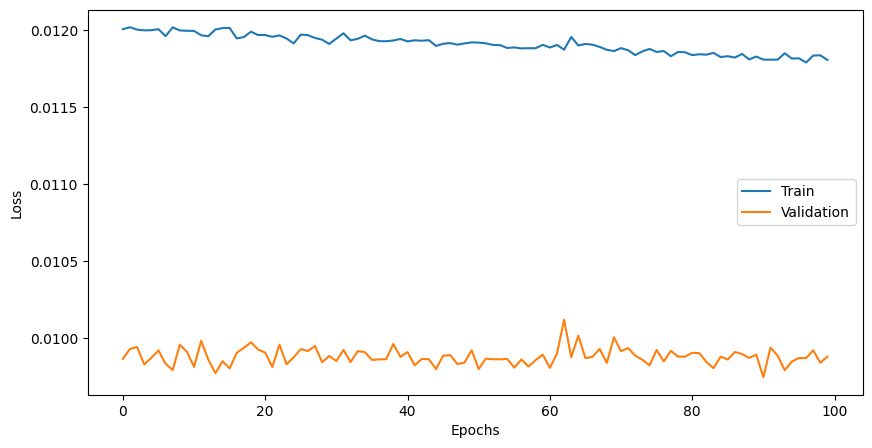

In [159]:
model.plot_loss(history)

In [160]:
save_path = 'model_allgen_ mmd_weights17.h5'  # HDF5 格式保存权重文件

# 保存模型权重
model.save_weights(save_path)
print(f"模型权重已保存至 {save_path}")

模型权重已保存至 model_allgen_ mmd_weights17.h5


In [ ]:
import pickle  

# 使用pickle保存history对象
with open('training_clean_history2.pkl', 'wb') as file:
    pickle.dump(history.history, file)

print("History object saved using pickle.")

# 可视化

In [ ]:
from tensorflow.keras.models import load_model

# 加载权重
load_path = 'model_weights1.h5'
model.load_weights(load_path)
print(f"模型权重已从 {load_path} 加载")

# 送入encoder，获取z_mean
latent_features,z_mean, z_logvar = model.encoder([X_train, C_train, L_train])
latent_features_val,z_mean_val, z_logvar_val = model.encoder([X_val, C_val, L_val])

In [ ]:
# 降维
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_features)
val_latent_2d = pca.transform(latent_features_val)

print(f'潜在空间表示的形状: {latent_features.shape}')  # (样本数, latent_dim)

plt.figure(figsize=(8, 6))

# 训练集-黑色点
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], 
            c='black', label='Train Set', alpha=0.7, s=20)

# 验证集-蓝色点
plt.scatter(val_latent_2d[:, 0], val_latent_2d[:, 1], 
            c='dodgerblue', label='Validation Set', alpha=0.7, s=20)

plt.title('Visualization of the latent space for the training set and validation set')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# 加载权重
load_path = 'model_weights57s.h5'
model.load_weights(load_path)
print(f"模型权重已从 {load_path} 加载")

# 送入encoder，获取z_mean
latent_features,z_mean, z_logvar = model.decoder([X_train, C_train, L_train])
latent_features_val,z_mean_val, z_logvar_val = model.decoder([X_val, C_val, L_val])

In [ ]:
# 降维
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_features)
val_latent_2d = pca.transform(latent_features_val)

print(f'潜在空间表示的形状: {latent_features.shape}')  # (样本数, latent_dim)
plt.figure(figsize=(8, 6))

#可视化
import matplotlib.pyplot as plt
# plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.7)
# 训练集-黑色点
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], 
            c='black', label='Train Set', alpha=0.7, s=20)
# 验证集-蓝色点
plt.scatter(val_latent_2d[:, 0], val_latent_2d[:, 1], 
            c='dodgerblue', label='Validation Set', alpha=0.7, s=20)

plt.title('Visualization of the latent space for the training set and validation set')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.show()